# Análisis Descriptivo - ENAHO 2020 (Salud)

## Objetivo general

Identificar los factores sociodemográficos y de acceso a servicios de salud que se asocian con la presencia de enfermedades crónicas en la población de Lima, mediante un modelo de regresión logística que permita cuantificar la influencia de cada variable.

## Objetivos Específicos:

1. **Analizar** las correlaciones entre las variables independientes seleccionadas (tipo de seguro, sexo, nivel educativo, estado civil, parentesco y ubicación del centro de salud) y la presencia de enfermedades crónicas, identificando las asociaciones más significativas.
2. **Construir** un modelo de regresión logística que permita estimar la probabilidad de padecer una enfermedad crónica en función de las características sociodemográficas y de acceso a salud del individuo.
3. **Evaluar** e interpretar los coeficientes del modelo para determinar qué factores tienen mayor influencia en la probabilidad de padecer enfermedades crónicas, generando recomendaciones basadas en los hallazgos.

# ENAHO: Encuesta Nacional de Hogares del Perú

## ¿Qué es la ENAHO?

La ENAHO es la principal investigación estadística que realiza el INEI para conocer cómo viven los peruanos. Se aplica de forma continua durante todo el año en cada rincón del país, desde Lima hasta las comunidades más alejadas de la selva o la sierra. Es, en esencia, el "termómetro oficial" que usa el Estado para medir el bienestar de la población.

## ¿Para qué sirve?

La ENAHO cumple funciones críticas para las políticas públicas:

1. **Medición oficial de la pobreza**: Es la única fuente válida para determinar cuántos peruanos viven en pobreza monetaria o multidimensional. Sin esta encuesta, el gobierno no tendría forma de saber si la pobreza sube o baja.

2. **Diagnóstico de condiciones de vida**: Captura información sobre vivienda, acceso a educación, salud, situación laboral e ingresos familiares, lo que permite entender las brechas sociales.

3. **Evaluación de programas sociales**: Permite verificar si programas como Juntos, Pensión 65 o Qali Warma realmente llegan a los beneficiarios correctos y generan impacto.

4. **Actualización de la canasta básica**: Los datos alimentan el cálculo del costo de vida y la línea de pobreza.

## Metodología de muestreo

La ENAHO emplea un diseño **probabilístico, estratificado y polietápico**, lo que garantiza representatividad estadística en cada departamento:

| Característica | Descripción |
|----------------|-------------|
| **Probabilístico** | Cada hogar tiene una probabilidad conocida y no nula de ser seleccionado, eliminando sesgos de selección |
| **Estratificado** | La población se divide en estratos (por nivel socioeconómico y área geográfica) para asegurar cobertura de todos los grupos |
| **Polietápico** | Selección en dos etapas: primero se eligen conglomerados (~140 viviendas), luego se seleccionan viviendas específicas dentro de cada uno |

## Tamaño de muestra (2024-2025)

| Componente | Viviendas | Propósito |
|------------|-----------|-----------|
| **Muestra total anual** | ~36,954 | Cobertura completa para estimaciones departamentales |
| **Muestra panel** | ~11,814 | Hogares reencuestados para análisis de evolución temporal |
| **Muestra no panel** | ~25,140 | Hogares nuevos seleccionados aleatoriamente |

La recolección se realiza mediante tablets con GPS, permitiendo validación en tiempo real y georreferenciación precisa de cada vivienda encuestada.

## 1. Carga y Preparación de Datos
En esta sección cargaremos el dataset y el diccionario de datos. Nos enfocaremos en las variables resaltadas en el diccionario (variables 'coloreadas') para realizar una exploración inicial.

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl

# Configuración de gráficos
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
# Cargar datos
file_name = 'data.xlsx'
sheet_data = 'Enaho01-2020-400'
sheet_dic = 'Diccionario Enaho 400'

try:
    print("Cargando dataset...")
    df_data = pd.read_excel(file_name, sheet_name=0) # Asumimos hoja 0 si el nombre falla
    
    print("Cargando diccionario...")
    df_dic = pd.read_excel(file_name, sheet_name=sheet_dic)
    
    print(f"Dataset cargado: {df_data.shape[0]} filas, {df_data.shape[1]} columnas.")
except Exception as e:
    print(f"Error al cargar los archivos: {e}")


Cargando dataset...
Cargando diccionario...
Dataset cargado: 15545 filas, 123 columnas.


## 2. Identificación de Variables de Interés
Utilizaremos una función para identificar automáticamente las variables que están marcadas con color en el archivo Excel `data.xlsx` (Hoja: `Diccionario Enaho 400`).

In [65]:
def get_colored_variables(file_path, sheet_name):
    """
    Lee una hoja de Excel e identifica las celdas que tienen algún color de fondo.
    Retorna una lista de los valores de las celdas de la columna 'VARIABLE' asociadas a esas filas.
    """
    import openpyxl
    
    colored_vars = set()
    try:
        wb = openpyxl.load_workbook(file_path, data_only=True)
        if sheet_name not in wb.sheetnames:
            print(f"Hoja '{sheet_name}' no encontrada.")
            return []

        sheet = wb[sheet_name]
        
        variable_col_idx = None
        header_row = 1
        
        for cell in sheet[header_row]:
            if cell.value and "VARIABLE" in str(cell.value).upper():
                variable_col_idx = cell.column
                break
        
        if not variable_col_idx:
            print("No se encontró la columna 'VARIABLE'. Asumiendo columna B (índice 2).")
            variable_col_idx = 2

        print(f"Escaneando celdas coloreadas en '{sheet_name}'...")
        
        for row in sheet.iter_rows(min_row=2):
            for cell in row:
                is_colored = False
                if cell.fill and cell.fill.start_color:
                    color = cell.fill.start_color
                    
                    # Verificación RGB (Cubre A5A5A5)
                    if color.type == 'rgb':
                        # Ignoramos transparente/blanco: 00000000, FFFFFFFF
                        if color.rgb and color.rgb not in ['00000000', 'FFFFFFFF']:
                           is_colored = True
                    
                    # Verificación Indexed
                    elif color.type == 'indexed':
                        if color.index != 64:
                            is_colored = True
                            
                    # Verificación Theme (opcional, por si acaso)
                    elif color.type == 'theme':
                        is_colored = True

                if is_colored:
                    var_cell = sheet.cell(row=cell.row, column=variable_col_idx)
                    if var_cell.value:
                        colored_vars.add(str(var_cell.value).strip())

    except Exception as e:
        print(f"Error procesando Excel: {e}")
        return []

    return list(colored_vars)

# Ejecutamos la función
variables_coloreadas = get_colored_variables(file_name, sheet_dic)
print(f"Variables coloreadas detectadas: {len(variables_coloreadas)}")
print(variables_coloreadas)

# Filtramos solo las que existen en el dataset
vars_existentes = [v for v in variables_coloreadas if v in df_data.columns]
print(f"Variables encontradas en el dataset: {len(vars_existentes)} de {len(variables_coloreadas)}")

Escaneando celdas coloreadas en 'Diccionario Enaho 400'...
Variables coloreadas detectadas: 42
['P203', 'P4195', 'I41606', 'I41611', 'P208B', 'I41601', 'I41610', 'I41615', 'P207', 'TIPOCUESTIONARIO', 'I41605', 'NIVEL', 'P4193', 'I41604', 'P4194', 'TICUEST01A', 'AREA', 'DPTO', 'I41613', 'P4197', 'I41607', 'P4196', 'P400A3', 'P208A', 'I41614', 'P4192', 'I41602', 'P4198', 'I41616', 'P301A', 'I41609', 'P420A', 'CIUDAD', 'I41603', 'P401', 'I41608', 'TIPOENTREVISTA', 'P209', 'PROV', 'P4191', 'DISTRITO', 'I41612']
Variables encontradas en el dataset: 42 de 42


## 3. Análisis Exploratorio de Datos (EDA)

### 3.1. Exploración de las 42 variables
Trabajaremos exclusivamente con las 42 variables identificadas (coloreadas). A continuación, creamos un subconjunto de datos y generamos un resumen de sus tipos, descripciones y estadísticas básicas para entender mejor la información disponible.

In [66]:
# Creación del Dataframe Reducido (Solo las 42 variables)
df_eda = df_data[vars_existentes].copy()
print(f"Nuevo Dataframe 'df_eda' creado con dimensiones: {df_eda.shape}")

# Limpieza de nombres de columnas del diccionario (quitar espacios)
if 'df_dic' in locals():
    df_dic.columns = df_dic.columns.str.strip()
    # Eliminar 'TIPO DE VARIABLE' si existe
    if 'TIPO DE VARIABLE' in df_dic.columns:
        df_dic = df_dic.drop(columns=['TIPO DE VARIABLE'])

# Generar Tabla Resumen con Descripciones
summary_data = []


for var in vars_existentes:
    # Buscar información en el diccionario
    info = df_dic[df_dic['VARIABLE'] == var]
    
    if not info.empty:
        desc = info['DESCRIPCIÓN'].values[0]
    else:
        desc = 'Descripción no encontrada'
        
    # Estadísticas básicas del dato real
    col_data = df_eda[var]
    datos_faltantes = col_data.isnull().sum()
    valores_unicos = col_data.nunique()
    tipo_pandas = col_data.dtype
    
    summary_data.append({
        'Variable': var,
        'Descripción': desc,
        'Tipo (Pandas)': str(tipo_pandas),
        'Nulos': datos_faltantes,
        'Unicos': valores_unicos
    })

df_summary = pd.DataFrame(summary_data)

# Separar en Categoricás (Object) y Numéricas (Float/Int)
df_cat = df_summary[df_summary['Tipo (Pandas)'].str.contains('object')].sort_values(by='Nulos', ascending=False)
df_num = df_summary[~df_summary['Tipo (Pandas)'].str.contains('object')].sort_values(by='Nulos', ascending=False)

from IPython.display import display
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

print("### Variables Categoricas (Object)")
display(df_cat)

print("\n### Variables Numericas (Float/Int)")
display(df_num)


Nuevo Dataframe 'df_eda' creado con dimensiones: (15545, 42)
### Variables Categoricas (Object)


,Variable,Descripción,Tipo (Pandas),Nulos,Unicos
31,P420A,"El centro o establecimiento de salud donde generalmente acude, ¿Esta ubicado:",object,7445,3
11,NIVEL,Nivel del gasto en salud ( por hogar o persona ),object,5366,2
15,TICUEST01A,Origen de cuestionario,object,5366,2
37,P209,¿Cuál es su estado civil o conyugal?,object,2446,6
29,P301A,¿Cuál es el último año o grado de estudios y nivel que aprobó? - Nivel,object,479,13
21,P4196,El sistema de prestación de seguro de salud al cual Ud. está afiliado actualmente es: ¿Seguro universitario?,object,13,2
34,P401,"¿Padece de alguna enfermedad o malestar crónico (Artritis, hipertensión, asma, reumatismo, diabetes, tuberculosis, VIH, colesterol, etc.)?",object,13,2
39,P4191,El sistema de prestación de seguro de salud al cual Ud. está afiliado actualmente es: ¿EsSalud?,object,13,2
12,P4193,El sistema de prestación de seguro de salud al cual Ud. está afiliado actualmente es: ¿Entidad prestadora de salud?,object,13,2
14,P4194,El sistema de prestación de seguro de salud al cual Ud. está afiliado actualmente es: ¿Seguro de FF.AA / Policiales?,object,13,2



### Variables Numericas (Float/Int)


,Variable,Descripción,Tipo (Pandas),Nulos,Unicos
28,I41616,"(Imputado, deflactado, anualizado) ¿Cuánto fue el monto total por la compra o servicio?: Atenciones de parto",float64,15535,10
6,I41610,"(Imputado, deflactado, anualizado) ¿Cuánto fue el monto total por la compra o servicio?: Control de Salud de los Niños",float64,15534,11
7,I41615,"(Imputado, deflactado, anualizado) ¿Cuánto fue el monto total por la compra o servicio?: Controles por embarazo",float64,15524,20
10,I41605,"(Imputado, deflactado, anualizado) ¿Cuánto fue el monto total por la compra o servicio?: Otros Exámenes (Hemodiálisis, etc.)",float64,15508,36
30,I41609,"(Imputado, deflactado, anualizado) ¿Cuánto fue el monto total por la compra o servicio?: Vacunas",float64,15501,30
24,I41614,"(Imputado, deflactado, anualizado) ¿Cuánto fue el monto total por la compra o servicio?: Intervención Quirúrgica",float64,15482,50
18,I41613,"(Imputado, deflactado, anualizado) ¿Cuánto fue el monto total por la compra o servicio?: Hospitalización",float64,15475,54
13,I41604,"(Imputado, deflactado, anualizado) ¿Cuánto fue el monto total por la compra o servicio?: Rayos X, Tomografía, etc",float64,15465,64
33,I41603,"(Imputado, deflactado, anualizado) ¿Cuánto fue el monto total por la compra o servicio?: Análisis",float64,15418,82
4,P208B,¿Qúe edad tiene en años cumplidos? (En meses),float64,15411,12


=== Variables con más del 60% de valores nulos ===

Total de variables con más del 60% de nulos: 17



,Variable,Porcentaje_Nulos,Cantidad_Nulos,Cantidad_Validos
0,I41616,99.94,15535,10
1,I41610,99.93,15534,11
2,I41615,99.86,15524,21
3,I41605,99.76,15508,37
4,I41609,99.72,15501,44
5,I41614,99.59,15482,63
6,I41613,99.55,15475,70
7,I41604,99.49,15465,80
8,I41603,99.18,15418,127
9,P208B,99.14,15411,134


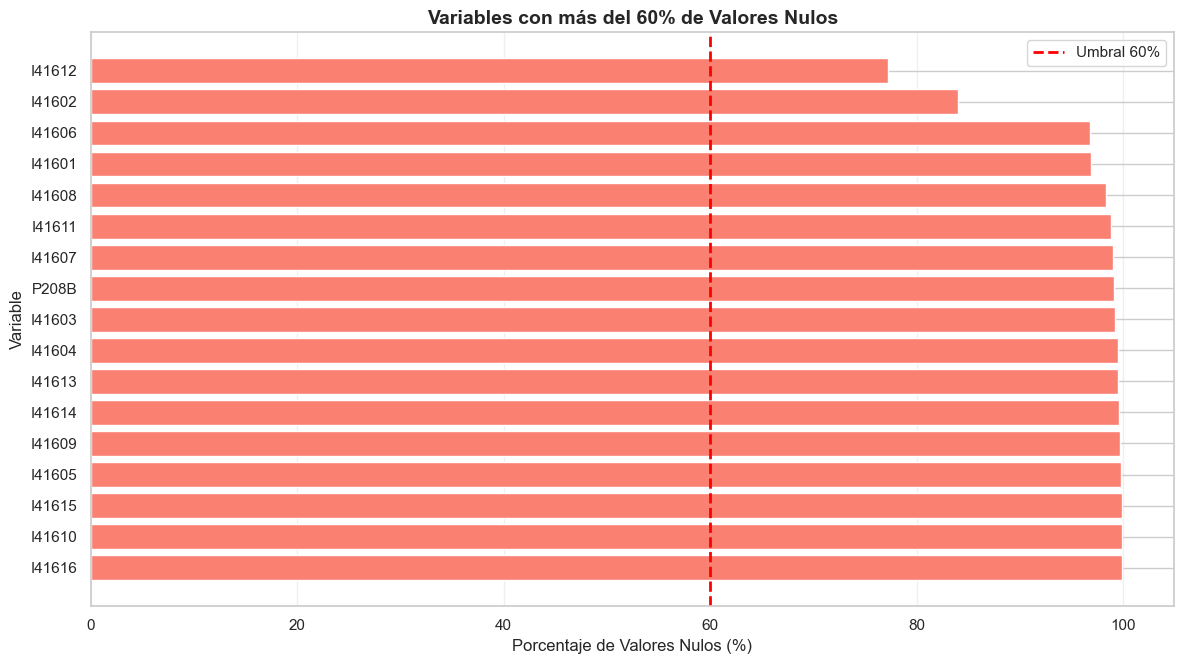

In [67]:
# Identificar variables con más del 60% de valores nulos
umbral_nulos = 0.60
total_filas = len(df_eda)

# Calcular porcentaje de nulos por variable
porcentaje_nulos = (df_eda.isnull().sum() / total_filas).sort_values(ascending=False)

# Filtrar variables con más del 60% de nulos
vars_con_muchos_nulos = porcentaje_nulos[porcentaje_nulos > umbral_nulos]

print(f"=== Variables con más del {umbral_nulos*100:.0f}% de valores nulos ===\n")
print(f"Total de variables con más del {umbral_nulos*100:.0f}% de nulos: {len(vars_con_muchos_nulos)}\n")

if len(vars_con_muchos_nulos) > 0:
    # Crear DataFrame para mejor visualización
    df_nulos = pd.DataFrame({
        'Variable': vars_con_muchos_nulos.index,
        'Porcentaje_Nulos': (vars_con_muchos_nulos.values * 100).round(2),
        'Cantidad_Nulos': (vars_con_muchos_nulos.values * total_filas).astype(int),
        'Cantidad_Validos': (total_filas - (vars_con_muchos_nulos.values * total_filas)).astype(int)
    })
    
    display(df_nulos)
    
    # Visualización
    plt.figure(figsize=(12, max(6, len(vars_con_muchos_nulos) * 0.4)))
    plt.barh(df_nulos['Variable'], df_nulos['Porcentaje_Nulos'], color='salmon')
    plt.xlabel('Porcentaje de Valores Nulos (%)', fontsize=12)
    plt.ylabel('Variable', fontsize=12)
    plt.title(f'Variables con más del {umbral_nulos*100:.0f}% de Valores Nulos', fontsize=14, fontweight='bold')
    plt.axvline(x=umbral_nulos*100, color='red', linestyle='--', linewidth=2, label=f'Umbral {umbral_nulos*100:.0f}%')
    plt.legend()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("✓ No se encontraron variables con más del 60% de valores nulos.")

#### Observaciones

- Se descartan las 17 variables mencionadas anteriormente por predominancia de nulos, probablemente hayan sido impuestos incorrectamente.

In [68]:
# Eliminar columnas con más del 60% de valores nulos de df_eda
columnas_a_eliminar = [
    'I41616', 'I41610', 'I41615', 'I41605', 'I41609', 'I41614', 
    'I41613', 'I41604', 'I41603', 'P208B', 'I41607', 'I41611', 
    'I41608', 'I41601', 'I41606', 'I41602', 'I41612'
]

print(f"Dimensiones de df_eda ANTES de eliminar columnas: {df_eda.shape}")
print(f"Columnas a eliminar: {len(columnas_a_eliminar)}")

# Verificar qué columnas existen en df_eda
columnas_existentes = [col for col in columnas_a_eliminar if col in df_eda.columns]
columnas_no_encontradas = [col for col in columnas_a_eliminar if col not in df_eda.columns]

if columnas_no_encontradas:
    print(f"\n⚠️ Columnas no encontradas en df_eda: {columnas_no_encontradas}")

# Eliminar las columnas que existen
if columnas_existentes:
    df_eda = df_eda.drop(columns=columnas_existentes)
    print(f"\n✓ Se eliminaron {len(columnas_existentes)} columnas con más del 60% de nulos")
    print(f"Dimensiones de df_eda DESPUÉS de eliminar columnas: {df_eda.shape}")
    print(f"\nColumnas eliminadas: {columnas_existentes}")
else:
    print("\n⚠️ No se encontraron columnas para eliminar en df_eda")

Dimensiones de df_eda ANTES de eliminar columnas: (15545, 42)
Columnas a eliminar: 17

✓ Se eliminaron 17 columnas con más del 60% de nulos
Dimensiones de df_eda DESPUÉS de eliminar columnas: (15545, 25)

Columnas eliminadas: ['I41616', 'I41610', 'I41615', 'I41605', 'I41609', 'I41614', 'I41613', 'I41604', 'I41603', 'P208B', 'I41607', 'I41611', 'I41608', 'I41601', 'I41606', 'I41602', 'I41612']


### 3.2 Selección de Variable Objetivo (Y) - Análisis de Variables Binarias

Estudiaremos las variables categóricas binarias (2 valores únicos) para elegir nuestra variable objetivo (Y). Buscamos una variable cuya distribución de clases sea relativamente balanceada para asegurar un buen desempeño de los modelos predictivos.

| Concepto | Detalle |
|----------|---------|
| **Cálculo** | Distribución de frecuencias y proporción de cada clase. |
| **Por qué** | Verificar si la variable está balanceada. |
| **Qué buscar** | Evitar que una categoría represente >90% de los datos. Se busca idealmente una proporción entre 20% y 80% para ambas clases. |

In [69]:
# Filtrar variables categóricas con exactamente 2 valores únicos
binary_vars = df_cat[df_cat['Unicos'] == 2]['Variable'].tolist()
results = []

for var in binary_vars:
    # Obtener descripción
    desc = df_cat[df_cat['Variable'] == var]['Descripción'].values[0]
    
    # Calcular conteos excluyendo nulos
    counts = df_eda[var].value_counts(dropna=True)
    total = counts.sum()
    
    # Formatear la distribución string
    dist_parts = []
    max_prop = 0
    
    if total > 0:
        max_prop = counts.max() / total
        for cat, count in counts.items():
            prop = count / total
            dist_parts.append(f"{cat}: {prop:.1%} ({count})")
    else:
        dist_parts.append("Sin datos")
    
    # Evaluación del balance
    status = "Balanceado (OK)"
    if max_prop > 0.9:
        status = "Desbalanceado (>90%)"
    elif total == 0:
        status = "Sin datos"
        
    results.append({
        'Variable': var,
        'Descripción': desc,
        'Distribución (Clase: % (n))': " | ".join(dist_parts),
        'Estado': status
    })

df_binary_analysis = pd.DataFrame(results)

print(f"Se analizaron {len(binary_vars)} variables binarias.")
print("Mostrando resultados ordenados por Estado (los Desbalanceados primero para descartar):")
display(df_binary_analysis.sort_values(by='Estado', ascending=True))

Se analizaron 14 variables binarias.
Mostrando resultados ordenados por Estado (los Desbalanceados primero para descartar):


,Variable,Descripción,Distribución (Clase: % (n)),Estado
0,NIVEL,Nivel del gasto en salud ( por hogar o persona ),Gastos en salud a nivel personal: 80.8% (8228) | Gastos en salud consolidados a nivel de hogar: 19.2% (1951),Balanceado (OK)
3,P401,"¿Padece de alguna enfermedad o malestar crónico (Artritis, hipertensión, asma, reumatismo, diabetes, tuberculosis, VIH, colesterol, etc.)?",No: 57.1% (8871) | Si: 42.9% (6661),Balanceado (OK)
4,P4191,El sistema de prestación de seguro de salud al cual Ud. está afiliado actualmente es: ¿EsSalud?,No: 67.1% (10427) | EsSalud: 32.9% (5105),Balanceado (OK)
8,P4195,El sistema de prestación de seguro de salud al cual Ud. está afiliado actualmente es: ¿Seguro integral de salud (SIS)?,No: 63.0% (9783) | Seguro Integral de Salud (SIS): 37.0% (5749),Balanceado (OK)
11,TIPOENTREVISTA,Tipo de entrevista,presencial: 52.2% (8113) | telefónico: 47.8% (7430),Balanceado (OK)
13,P207,Sexo,Mujer: 50.8% (7900) | Hombre: 49.2% (7643),Balanceado (OK)
1,TICUEST01A,Origen de cuestionario,Cuestionario en Tablet: 100.0% (10178) | Cuestionario en hojas: 0.0% (1),Desbalanceado (>90%)
2,P4196,El sistema de prestación de seguro de salud al cual Ud. está afiliado actualmente es: ¿Seguro universitario?,No: 99.6% (15470) | Seguro Universitario: 0.4% (62),Desbalanceado (>90%)
5,P4193,El sistema de prestación de seguro de salud al cual Ud. está afiliado actualmente es: ¿Entidad prestadora de salud?,No: 98.0% (15215) | Entidad Prestadora de Salud: 2.0% (317),Desbalanceado (>90%)
6,P4194,El sistema de prestación de seguro de salud al cual Ud. está afiliado actualmente es: ¿Seguro de FF.AA / Policiales?,No: 98.1% (15239) | Seguro FF.AA./Policiales: 1.9% (293),Desbalanceado (>90%)


#### Observaciones:

- **AREA**: Esta variable esta desbalanceada, predomina el area urbano, asi que no lo vamos a considerar. Por conocimiento general, se sabe que en areas rurales hay un peor acceso a servicios de salud. Y considerando el desbalance de los datos, lo mejor seria descartarla.
- **TICUEST01A**: Esta varialbe es irrelevante. Solo una persona lo lleno a mano.
- **TIPOENTREVISTA**: Irrelevante
> Las variables `P4191` a `P4198` representan el tipo de seguro de las personas, independientemente no aportan mucho valor, pero si las agrupamos podremos obtener datos mas interesantes


Variables a considerar --> `NIVEL, P401, P207`

### 3.3 Generación de Nueva Variable: Tipo de Seguro

A partir de las variables `P4191` a `P4198`, crearemos una nueva variable numérica `TIPO_SEGURO` para clasificar el tipo de cobertura de cada persona.

**Codificación (cada variable tiene su propio código):**
*   **0**: Ninguno (sin seguro)
*   **1**: EsSalud (P4191)
*   **2**: Seguro Privado de Salud (P4192)
*   **3**: Entidad Prestadora de Salud - EPS (P4193)
*   **4**: Seguro FF.AA / Policiales (P4194)
*   **5**: Seguro Integral de Salud - SIS (P4195)
*   **6**: Seguro Universitario (P4196)
*   **7**: Seguro Escolar Privado (P4197)
*   **8**: Otro (P4198)


In [70]:
# Definimos la función de clasificación
def clasificar_seguro(row):
    # Función auxiliar para verificar si tiene el seguro (ignora 'No' y nulos)
    def has(col):
        val = row[col]
        # Verificamos que no sea nulo y que no sea la cadena 'No'
        if pd.isna(val) or val == 'No':
            return False
        return True

    # Cada variable tiene su propio código
    if has('P4191'):  # EsSalud
        return 1
    if has('P4192'):  # Seguro Privado de Salud
        return 2
    if has('P4193'):  # Entidad Prestadora de Salud (EPS)
        return 3
    if has('P4194'):  # Seguro FF.AA / Policiales
        return 4
    if has('P4195'):  # Seguro Integral de Salud (SIS)
        return 5
    if has('P4196'):  # Seguro Universitario
        return 6
    if has('P4197'):  # Seguro Escolar Privado
        return 7
    if has('P4198'):  # Otro
        return 8
        
    # Caso 0: Ninguno
    return 0

# Aplicamos la transformación
df_eda['TIPO_SEGURO'] = df_eda.apply(clasificar_seguro, axis=1)

# Visualizamos los resultados
counts = df_eda['TIPO_SEGURO'].value_counts().sort_index()

# Etiquetas para cada tipo de seguro
labels = {
    0: 'Ninguno',
    1: 'EsSalud',
    2: 'Seguro Privado',
    3: 'EPS',
    4: 'FF.AA/Policiales',
    5: 'SIS',
    6: 'Universitario',
    7: 'Escolar Privado',
    8: 'Otro'
}

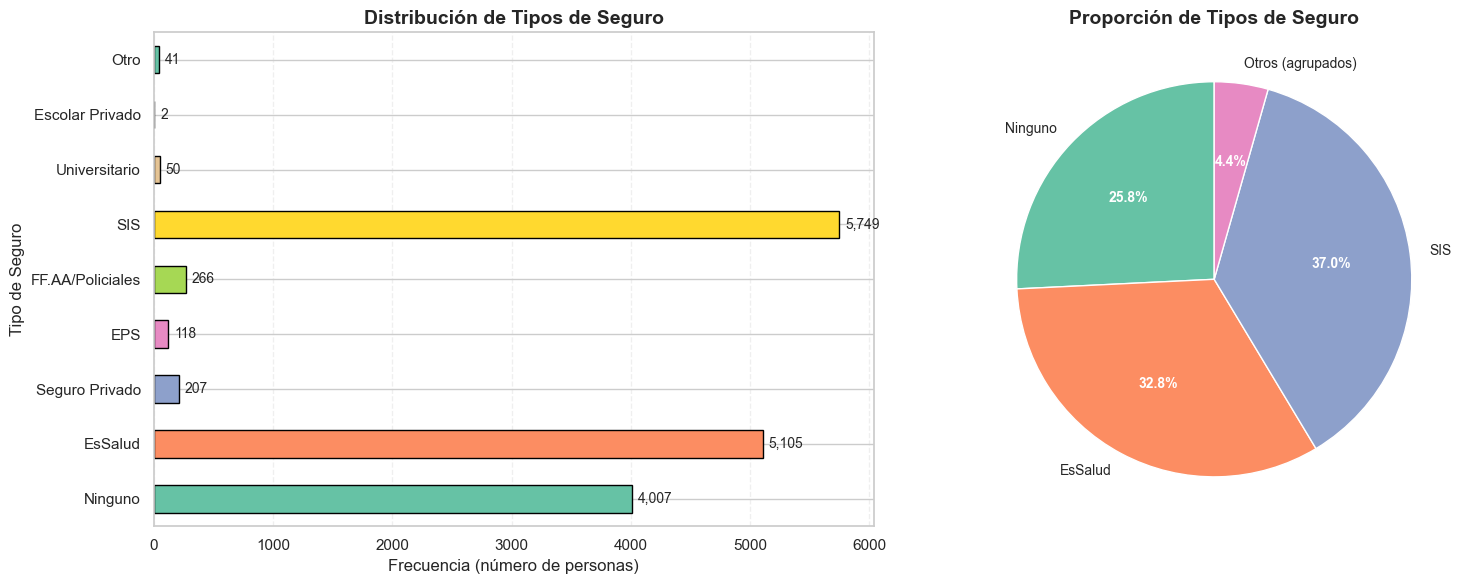


=== Estadísticas Descriptivas ===
Total de registros: 15,545

Tipo de seguro más común: SIS (5,749 personas, 37.0%)
Tipo de seguro menos común: Escolar Privado (2 personas, 0.0%)

Personas sin seguro: 4,007 (25.8%)
Personas con algún seguro: 11,538 (74.2%)


In [71]:
# Visualización de la variable TIPO_SEGURO
import matplotlib.pyplot as plt
import seaborn as sns

# Preparar datos
labels_dict = {
    0: 'Ninguno',
    1: 'EsSalud',
    2: 'Seguro Privado',
    3: 'EPS',
    4: 'FF.AA/Policiales',
    5: 'SIS',
    6: 'Universitario',
    7: 'Escolar Privado',
    8: 'Otro'
}

counts = df_eda['TIPO_SEGURO'].value_counts().sort_index()
counts_labeled = counts.rename(index=labels_dict)

# Crear figura con 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 1. Gráfico de Barras Horizontal
colors = sns.color_palette('Set2', len(counts_labeled))
counts_labeled.plot(kind='barh', ax=ax1, color=colors, edgecolor='black')
ax1.set_title('Distribución de Tipos de Seguro', fontsize=14, fontweight='bold')
ax1.set_xlabel('Frecuencia (número de personas)', fontsize=12)
ax1.set_ylabel('Tipo de Seguro', fontsize=12)
ax1.grid(axis='x', alpha=0.3, linestyle='--')

# Agregar valores en las barras
for i, v in enumerate(counts_labeled.values):
    ax1.text(v + 50, i, f'{v:,}', va='center', fontsize=10)

# 2. Gráfico de Pastel
# Filtrar categorías muy pequeñas para mejor visualización
threshold = 0.02  # 2%
total = counts_labeled.sum()
counts_pie = counts_labeled.copy()
small_categories = counts_pie[counts_pie / total < threshold]

if len(small_categories) > 0:
    counts_pie = counts_pie[counts_pie / total >= threshold]
    counts_pie['Otros (agrupados)'] = small_categories.sum()

# Crear pastel
wedges, texts, autotexts = ax2.pie(
    counts_pie.values,
    labels=counts_pie.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette('Set2', len(counts_pie)),
    textprops={'fontsize': 10}
)

# Mejorar legibilidad de porcentajes
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

ax2.set_title('Proporción de Tipos de Seguro', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Estadísticas adicionales
print("\n=== Estadísticas Descriptivas ===")
print(f"Total de registros: {total:,}")
print(f"\nTipo de seguro más común: {counts_labeled.idxmax()} ({counts_labeled.max():,} personas, {counts_labeled.max()/total*100:.1f}%)")
print(f"Tipo de seguro menos común: {counts_labeled.idxmin()} ({counts_labeled.min():,} personas, {counts_labeled.min()/total*100:.1f}%)")
print(f"\nPersonas sin seguro: {counts_labeled.get('Ninguno', 0):,} ({counts_labeled.get('Ninguno', 0)/total*100:.1f}%)")
print(f"Personas con algún seguro: {total - counts_labeled.get('Ninguno', 0):,} ({(total - counts_labeled.get('Ninguno', 0))/total*100:.1f}%)")

### 3.4 Exploramos la ubicacion

=== Visualización de Variables Geográficas ===


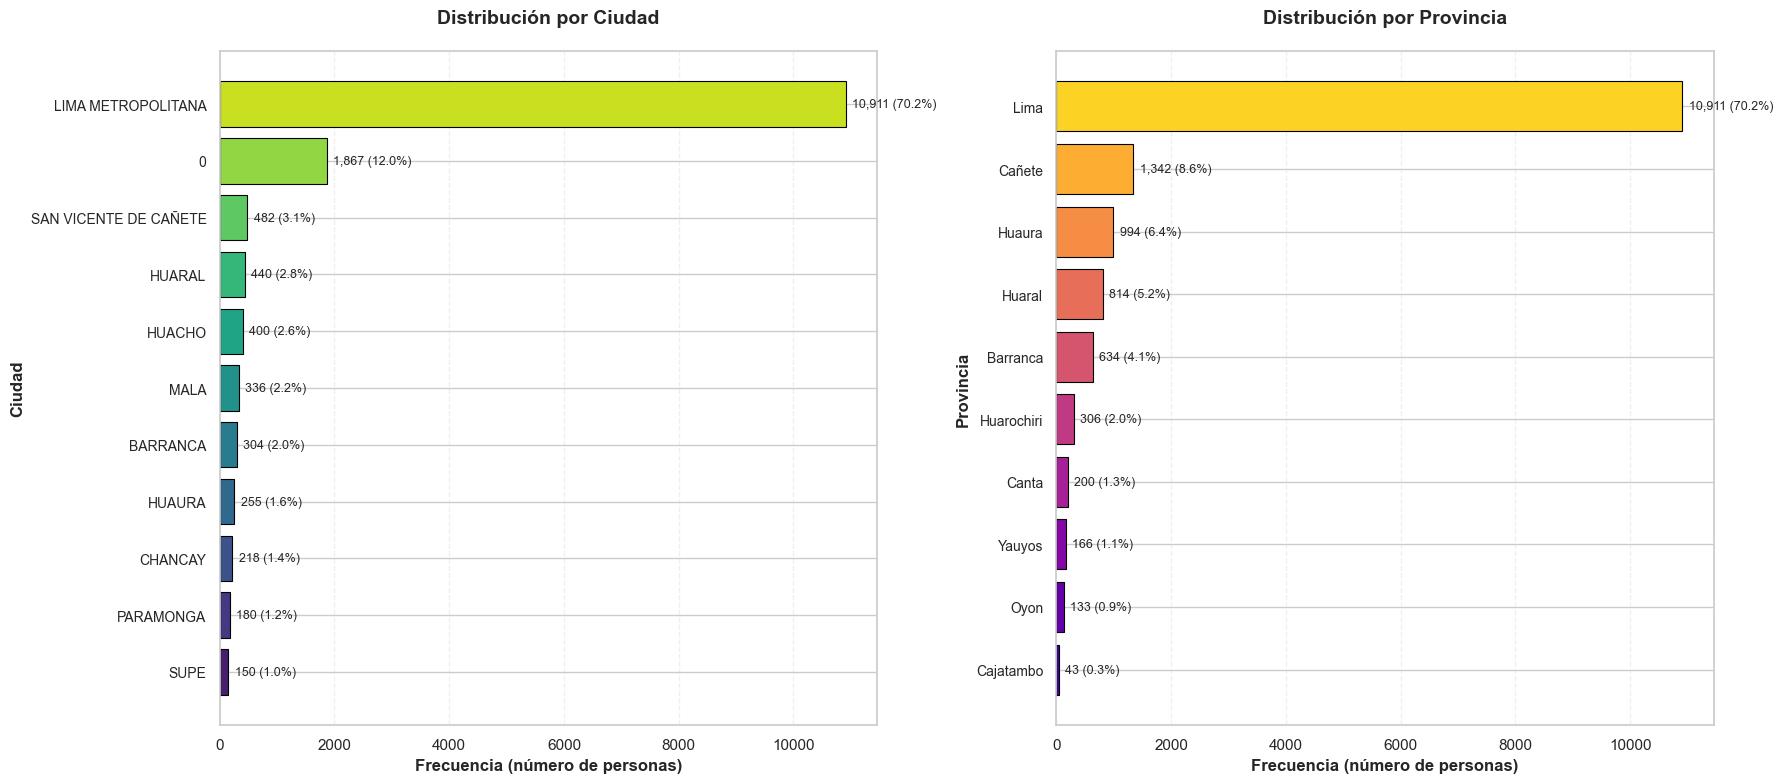


ESTADÍSTICAS DESCRIPTIVAS

📍 CIUDAD:
  • Total de ciudades únicas: 11
  • Ciudad más frecuente: LIMA METROPOLITANA (10,911 personas, 70.2%)
  • Ciudad menos frecuente: SUPE (150 personas, 1.0%)

🗺️  PROVINCIA:
  • Total de provincias únicas: 10
  • Provincia más frecuente: Lima (10,911 personas, 70.2%)
  • Provincia menos frecuente: Cajatambo (43 personas, 0.3%)

TABLA DETALLADA DE VALORES

--- CIUDAD ---


,Ciudad,Frecuencia,Porcentaje
10,LIMA METROPOLITANA,10911,70.20%
9,0,1867,12.01%
8,SAN VICENTE DE CAÑETE,482,3.10%
7,HUARAL,440,2.83%
6,HUACHO,400,2.57%
5,MALA,336,2.16%
4,BARRANCA,304,1.96%
3,HUAURA,255,1.64%
2,CHANCAY,218,1.40%
1,PARAMONGA,180,1.16%



--- PROVINCIA ---


,Provincia,Frecuencia,Porcentaje
9,Lima,10911,70.20%
8,Cañete,1342,8.63%
7,Huaura,994,6.40%
6,Huaral,814,5.24%
5,Barranca,634,4.08%
4,Huarochiri,306,1.97%
3,Canta,200,1.29%
2,Yauyos,166,1.07%
1,Oyon,133,0.86%
0,Cajatambo,43,0.28%


In [72]:
# Visualización de variables geográficas: CIUDAD y PROV
import matplotlib.pyplot as plt
import seaborn as sns

print("=== Visualización de Variables Geográficas ===")

# Preparar datos
ciudad_counts = df_eda['CIUDAD'].value_counts().sort_values(ascending=True)
prov_counts = df_eda['PROV'].value_counts().sort_values(ascending=True)

# Crear figura con 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Paleta de colores
colors_ciudad = sns.color_palette('viridis', len(ciudad_counts))
colors_prov = sns.color_palette('plasma', len(prov_counts))

# 1. Gráfico de CIUDAD
bars1 = ax1.barh(range(len(ciudad_counts)), ciudad_counts.values, 
                  color=colors_ciudad, edgecolor='black', linewidth=0.8)
ax1.set_yticks(range(len(ciudad_counts)))
ax1.set_yticklabels(ciudad_counts.index, fontsize=10)
ax1.set_xlabel('Frecuencia (número de personas)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Ciudad', fontsize=12, fontweight='bold')
ax1.set_title('Distribución por Ciudad', fontsize=14, fontweight='bold', pad=20)
ax1.grid(axis='x', alpha=0.3, linestyle='--')

# Agregar valores en las barras
for i, (v, label) in enumerate(zip(ciudad_counts.values, ciudad_counts.index)):
    percentage = (v / ciudad_counts.sum()) * 100
    ax1.text(v + max(ciudad_counts.values) * 0.01, i, 
             f'{v:,} ({percentage:.1f}%)', 
             va='center', fontsize=9)

# 2. Gráfico de PROVINCIA
bars2 = ax2.barh(range(len(prov_counts)), prov_counts.values, 
                  color=colors_prov, edgecolor='black', linewidth=0.8)
ax2.set_yticks(range(len(prov_counts)))
ax2.set_yticklabels(prov_counts.index, fontsize=10)
ax2.set_xlabel('Frecuencia (número de personas)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Provincia', fontsize=12, fontweight='bold')
ax2.set_title('Distribución por Provincia', fontsize=14, fontweight='bold', pad=20)
ax2.grid(axis='x', alpha=0.3, linestyle='--')

# Agregar valores en las barras
for i, (v, label) in enumerate(zip(prov_counts.values, prov_counts.index)):
    percentage = (v / prov_counts.sum()) * 100
    ax2.text(v + max(prov_counts.values) * 0.01, i, 
             f'{v:,} ({percentage:.1f}%)', 
             va='center', fontsize=9)

plt.tight_layout()
plt.show()

# Estadísticas descriptivas
print("\n" + "="*80)
print("ESTADÍSTICAS DESCRIPTIVAS")
print("="*80)

print("\n📍 CIUDAD:")
print(f"  • Total de ciudades únicas: {len(ciudad_counts)}")
print(f"  • Ciudad más frecuente: {ciudad_counts.index[-1]} ({ciudad_counts.iloc[-1]:,} personas, {ciudad_counts.iloc[-1]/ciudad_counts.sum()*100:.1f}%)")
print(f"  • Ciudad menos frecuente: {ciudad_counts.index[0]} ({ciudad_counts.iloc[0]:,} personas, {ciudad_counts.iloc[0]/ciudad_counts.sum()*100:.1f}%)")

print("\n🗺️  PROVINCIA:")
print(f"  • Total de provincias únicas: {len(prov_counts)}")
print(f"  • Provincia más frecuente: {prov_counts.index[-1]} ({prov_counts.iloc[-1]:,} personas, {prov_counts.iloc[-1]/prov_counts.sum()*100:.1f}%)")
print(f"  • Provincia menos frecuente: {prov_counts.index[0]} ({prov_counts.iloc[0]:,} personas, {prov_counts.iloc[0]/prov_counts.sum()*100:.1f}%)")

# Tabla detallada de valores
print("\n" + "="*80)
print("TABLA DETALLADA DE VALORES")
print("="*80)

print("\n--- CIUDAD ---")
ciudad_df = pd.DataFrame({
    'Ciudad': ciudad_counts.index,
    'Frecuencia': ciudad_counts.values,
    'Porcentaje': [f"{(v/ciudad_counts.sum())*100:.2f}%" for v in ciudad_counts.values]
}).sort_values('Frecuencia', ascending=False)
display(ciudad_df)

print("\n--- PROVINCIA ---")
prov_df = pd.DataFrame({
    'Provincia': prov_counts.index,
    'Frecuencia': prov_counts.values,
    'Porcentaje': [f"{(v/prov_counts.sum())*100:.2f}%" for v in prov_counts.values]
}).sort_values('Frecuencia', ascending=False)
display(prov_df)

#### Observaciones:

- La mayoria de personas viene de Lima, considerando el contexto centralizado del pais, esto podria afectar la data. Por eso, no consideraremos la ubicacion

### 3.5 Nivel de educacion

- Exploramos el nivel educativo y lo encodeamos, ya que la jerarquia importa 

In [73]:
# Exploración Visual de P301A (Nivel Educativo)
var_name = 'P301A'

# Determinar dataframe a usar
df_plot = None
if 'data_analysis' in locals():
    df_plot = data_analysis
elif 'df_filtered' in locals():
    df_plot = df_filtered

if df_plot is not None and var_name in df_plot.columns:
    # Calcular frecuencias
    # Ordenamos por cantidad para ver los más frecuentes primero en el gráfico (o podríamos intentar un orden lógico si existiera)

    conteo = df_plot[var_name].value_counts().sort_values(ascending=False)
    
    # Imprimir valores textuales
    print("=== Valores y Frecuencias ===")
    print(conteo)

    # Graficar
    plt.figure(figsize=(12, 8))
    # Usamos barplot horizontal para que se lean bien las etiquetas de niveles educativos largos
    ax = sns.barplot(x=conteo.values, y=conteo.index, palette='viridis')
    
    plt.title(f'Distribución de Frecuencia: {var_name} (Nivel Educativo)', fontsize=15)
    plt.xlabel('Cantidad de Personas', fontsize=12)
    plt.ylabel('Nivel Educativo', fontsize=12)
    
    # Agregar etiquetas de valores al final de las barras
    for i, v in enumerate(conteo.values):
        ax.text(v + (max(conteo.values)*0.01), i, f'{v}', color='black', va='center', fontweight='bold')
    
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
else:
    print(f"Variable {var_name} no encontrada para graficar.")

Variable P301A no encontrada para graficar.


In [74]:
import pandas as pd
import numpy as np

# Definir la jerarquía del sistema educativo peruano (de menor a mayor nivel)
NIVEL_EDUCATIVO_ORDEN = {
    'Sin Nivel': 0,
    'Inicial': 1,
    'Básica especial': 2,
    'Primaria Incompleta': 3,
    'Primaria Completa': 4,
    'Secundaria Incompleta': 5,
    'Secundaria Completa': 6,
    'Superior No Universitaria Incompleta': 7,
    'Superior No Universitaria Completa': 8,
    'Superior Universitaria Incompleta': 9,
    'Superior Universitaria Completa': 10,
    'Maestria/Doctorado': 11,
    '99': np.nan  # No sabe / No responde -> tratamos como missing
}
try:
    if 'P301A' in df_eda.columns:
        df_eda['P301A_encoded'] = df_eda['P301A'].map(NIVEL_EDUCATIVO_ORDEN)
        print("Codificación realizada. Muestra de resultados:")
        print(df_eda[['P301A', 'P301A_encoded']].head())
    else:
        print("La columna 'P301A' no existe en el DataFrame actual.")
except NameError:
    print("El DataFrame 'df' no está definido. Por favor cárgalo antes de ejecutar esta celda.")

Codificación realizada. Muestra de resultados:
                               P301A  P301A_encoded
0  Superior Universitaria Incompleta            9.0
1  Superior Universitaria Incompleta            9.0
2  Superior Universitaria Incompleta            9.0
3  Superior Universitaria Incompleta            9.0
4                Secundaria Completa            6.0


### 3.6 Exploracion de NIVEL

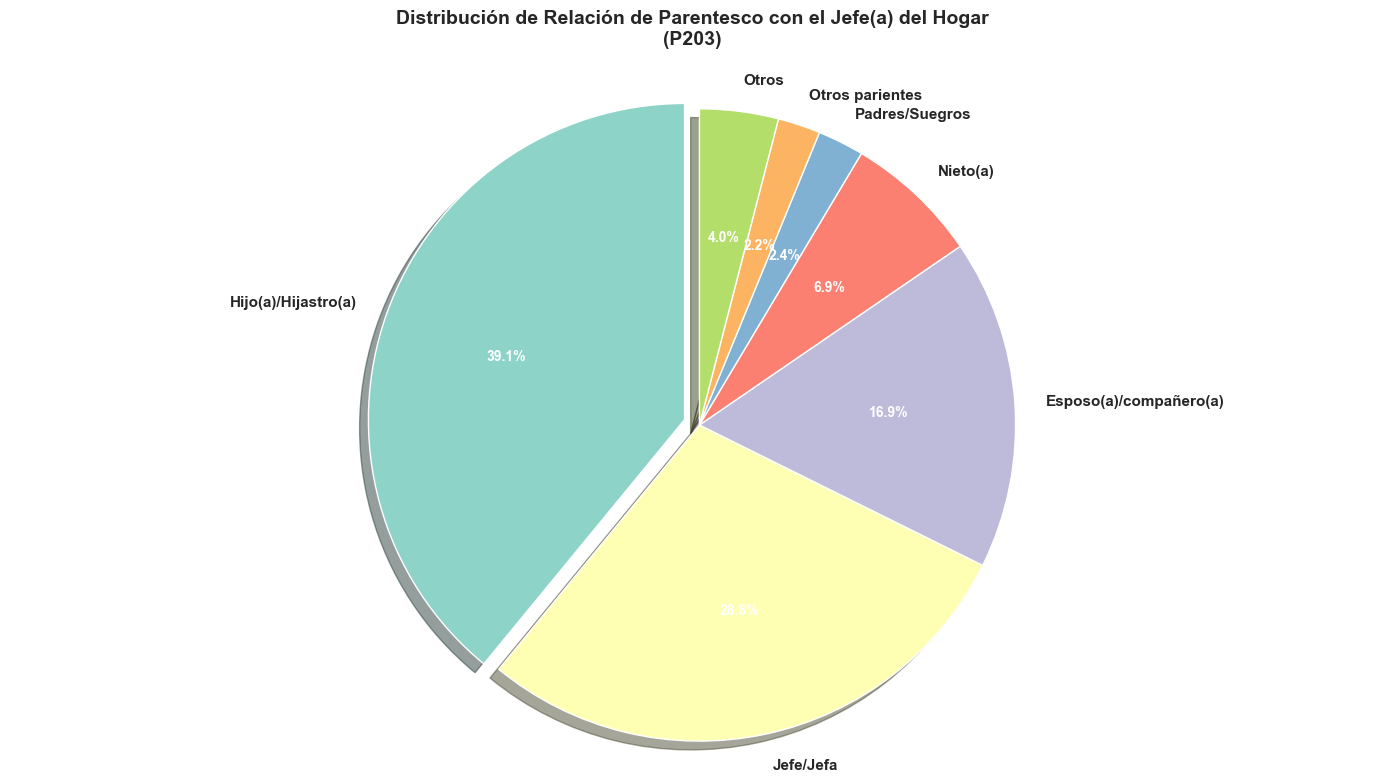

In [75]:
# Análisis de P203 - Relación de parentesco con el jefe(a) del hogar

# 1. Valores únicos y frecuencias
value_counts = df_eda['P203'].value_counts().sort_values(ascending=False)

# 2. Porcentajes
percentages = df_eda['P203'].value_counts(normalize=True).sort_values(ascending=False) * 100


# Preparar datos para el gráfico
# Filtrar categorías con menos del 2% para agruparlas en "Otros"
umbral = 2.0
categorias_principales = percentages[percentages >= umbral]
otros = percentages[percentages < umbral].sum()

if otros > 0:
    categorias_principales['Otros'] = otros

# Crear figura
plt.figure(figsize=(14, 8))

# Colores personalizados
colors = sns.color_palette('Set3', len(categorias_principales))

# Crear gráfico de pastel
wedges, texts, autotexts = plt.pie(
    categorias_principales.values,
    labels=categorias_principales.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    explode=[0.05 if i == 0 else 0 for i in range(len(categorias_principales))],  # Destacar la categoría más grande
    shadow=True
)

# Mejorar la apariencia del texto
for text in texts:
    text.set_fontsize(11)
    text.set_weight('bold')

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(10)
    autotext.set_weight('bold')

plt.title('Distribución de Relación de Parentesco con el Jefe(a) del Hogar\n(P203)', 
          fontsize=14, fontweight='bold', pad=20)

plt.axis('equal')  # Para que el círculo sea perfecto
plt.tight_layout()
plt.show()


### 3.7 Encoding de Variables Categóricas

Aplicaremos encoding a las variables categóricas seleccionadas para prepararlas para el análisis:
- **NIVEL**: Label Encoding (binaria)
- **P203**: Label Encoding (relación de parentesco)
- **P209**: Label Encoding (estado civil)
- **P420A**: Label Encoding (ubicación centro de salud)
- **P207**: Label Encoding (sexo)
- **P401**: Label Encoding (enfermedad crónica - variable objetivo)

In [76]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np

# Crear una copia del dataframe para aplicar encoding
df_encoded = df_filtered.copy()

# Diccionario para almacenar los encoders y mapeos
encoders = {}
mapeos = {}

print("="*80)
print("APLICANDO ENCODING A VARIABLES CATEGÓRICAS")
print("="*80)

# 1. NIVEL - Variable binaria (Personal/Hogar)
if 'NIVEL' in df_encoded.columns:
    print("\n1. NIVEL (Nivel del gasto en salud)")
    print("-" * 40)
    
    # Primero, ver los valores únicos
    valores_unicos = df_encoded['NIVEL'].dropna().unique()
    print(f"Valores únicos: {valores_unicos}")
    
    # Crear encoder
    le_nivel = LabelEncoder()
    
    # Manejar nulos: crear una máscara para valores no nulos
    mask_nivel = df_encoded['NIVEL'].notna()
    
    # Aplicar encoding solo a valores no nulos
    df_encoded.loc[mask_nivel, 'NIVEL_encoded'] = le_nivel.fit_transform(df_encoded.loc[mask_nivel, 'NIVEL'])
    
    # Crear mapeo
    mapeo_nivel = dict(zip(le_nivel.classes_, le_nivel.transform(le_nivel.classes_)))
    mapeos['NIVEL'] = mapeo_nivel
    encoders['NIVEL'] = le_nivel
    
    print(f"Mapeo: {mapeo_nivel}")
    print(f"Valores nulos: {df_encoded['NIVEL'].isnull().sum()}")
    print(f"Distribución encoded:")
    print(df_encoded['NIVEL_encoded'].value_counts().sort_index())

# 2. P207 - Sexo
if 'P207' in df_encoded.columns:
    print("\n2. P207 (Sexo)")
    print("-" * 40)
    
    valores_unicos = df_encoded['P207'].dropna().unique()
    print(f"Valores únicos: {valores_unicos}")
    
    le_p207 = LabelEncoder()
    mask_p207 = df_encoded['P207'].notna()
    df_encoded.loc[mask_p207, 'P207_encoded'] = le_p207.fit_transform(df_encoded.loc[mask_p207, 'P207'])
    
    mapeo_p207 = dict(zip(le_p207.classes_, le_p207.transform(le_p207.classes_)))
    mapeos['P207'] = mapeo_p207
    encoders['P207'] = le_p207
    
    print(f"Mapeo: {mapeo_p207}")
    print(f"Valores nulos: {df_encoded['P207'].isnull().sum()}")
    print(f"Distribución encoded:")
    print(df_encoded['P207_encoded'].value_counts().sort_index())

# 3. P203 - Relación de parentesco
if 'P203' in df_encoded.columns:
    print("\n3. P203 (Relación de parentesco con el jefe del hogar)")
    print("-" * 40)
    
    valores_unicos = df_encoded['P203'].dropna().unique()
    print(f"Valores únicos ({len(valores_unicos)}): {valores_unicos}")
    
    le_p203 = LabelEncoder()
    mask_p203 = df_encoded['P203'].notna()
    df_encoded.loc[mask_p203, 'P203_encoded'] = le_p203.fit_transform(df_encoded.loc[mask_p203, 'P203'])
    
    mapeo_p203 = dict(zip(le_p203.classes_, le_p203.transform(le_p203.classes_)))
    mapeos['P203'] = mapeo_p203
    encoders['P203'] = le_p203
    
    print(f"Mapeo: {mapeo_p203}")
    print(f"Valores nulos: {df_encoded['P203'].isnull().sum()}")
    print(f"Distribución encoded:")
    print(df_encoded['P203_encoded'].value_counts().sort_index())

# 4. P209 - Estado civil
if 'P209' in df_encoded.columns:
    print("\n4. P209 (Estado civil o conyugal)")
    print("-" * 40)
    
    valores_unicos = df_encoded['P209'].dropna().unique()
    print(f"Valores únicos ({len(valores_unicos)}): {valores_unicos}")
    
    le_p209 = LabelEncoder()
    mask_p209 = df_encoded['P209'].notna()
    df_encoded.loc[mask_p209, 'P209_encoded'] = le_p209.fit_transform(df_encoded.loc[mask_p209, 'P209'])
    
    mapeo_p209 = dict(zip(le_p209.classes_, le_p209.transform(le_p209.classes_)))
    mapeos['P209'] = mapeo_p209
    encoders['P209'] = le_p209
    
    print(f"Mapeo: {mapeo_p209}")
    print(f"Valores nulos: {df_encoded['P209'].isnull().sum()}")
    print(f"Distribución encoded:")
    print(df_encoded['P209_encoded'].value_counts().sort_index())

# 5. P420A - Ubicación del centro de salud
if 'P420A' in df_encoded.columns:
    print("\n5. P420A (Ubicación del centro de salud)")
    print("-" * 40)
    
    valores_unicos = df_encoded['P420A'].dropna().unique()
    print(f"Valores únicos ({len(valores_unicos)}): {valores_unicos}")
    
    le_p420a = LabelEncoder()
    mask_p420a = df_encoded['P420A'].notna()
    df_encoded.loc[mask_p420a, 'P420A_encoded'] = le_p420a.fit_transform(df_encoded.loc[mask_p420a, 'P420A'])
    
    mapeo_p420a = dict(zip(le_p420a.classes_, le_p420a.transform(le_p420a.classes_)))
    mapeos['P420A'] = mapeo_p420a
    encoders['P420A'] = le_p420a
    
    print(f"Mapeo: {mapeo_p420a}")
    print(f"Valores nulos: {df_encoded['P420A'].isnull().sum()}")
    print(f"Distribución encoded:")
    print(df_encoded['P420A_encoded'].value_counts().sort_index())

# 6. P401 - Enfermedad crónica (Variable objetivo)
if 'P401' in df_encoded.columns:
    print("\n6. P401 (¿Padece de alguna enfermedad o malestar crónico?)")
    print("-" * 40)
    
    valores_unicos = df_encoded['P401'].dropna().unique()
    print(f"Valores únicos: {valores_unicos}")
    
    le_p401 = LabelEncoder()
    mask_p401 = df_encoded['P401'].notna()
    df_encoded.loc[mask_p401, 'P401_encoded'] = le_p401.fit_transform(df_encoded.loc[mask_p401, 'P401'])
    
    mapeo_p401 = dict(zip(le_p401.classes_, le_p401.transform(le_p401.classes_)))
    mapeos['P401'] = mapeo_p401
    encoders['P401'] = le_p401
    
    print(f"Mapeo: {mapeo_p401}")
    print(f"Valores nulos: {df_encoded['P401'].isnull().sum()}")
    print(f"Distribución encoded:")
    print(df_encoded['P401_encoded'].value_counts().sort_index())

print("\n" + "="*80)
print("RESUMEN DE ENCODING COMPLETADO")
print("="*80)
print(f"Nuevas columnas creadas: {[col for col in df_encoded.columns if '_encoded' in col]}")
print(f"\nDimensiones del DataFrame: {df_encoded.shape}")

APLICANDO ENCODING A VARIABLES CATEGÓRICAS

RESUMEN DE ENCODING COMPLETADO
Nuevas columnas creadas: ['NIVEL_encoded', 'P401_encoded', 'P207_encoded', 'P420A_encoded', 'P209_encoded', 'P301A_encoded', 'P203_encoded']

Dimensiones del DataFrame: (15545, 9)


## 4. Selección de Variables

### 4.1 Justificación de Eliminación de Variables

Tras el análisis exploratorio realizado en las secciones anteriores, hemos decidido trabajar con un conjunto reducido de variables que cumplen con los siguientes criterios:

1. **Calidad de datos**: Variables con bajo porcentaje de valores nulos
2. **Relevancia temática**: Variables relacionadas con salud, demografía y contexto socioeconómico
3. **Variabilidad**: Variables con distribución balanceada que permitan análisis significativos
4. **No redundancia**: Evitar variables que midan el mismo concepto

**Variables numéricas descartadas:**
La gran mayoría de las variables numéricas relacionadas con gastos en salud (I41601-I41616) fueron descartadas debido a la excesiva cantidad de valores nulos (>80%). Mantenerlas requeriría técnicas de imputación agresivas que podrían introducir sesgos significativos.

**Variables geográficas descartadas:**
Las variables CIUDAD, PROV y DISTRITO fueron excluidas del modelo final para mantener la simplicidad y generalización del análisis, aunque fueron exploradas en la fase de EDA.

---

### 4.2 Variables Seleccionadas para el Análisis

#### **Variable Dependiente (Y):**

**Y: P401** - *¿Padece de alguna enfermedad o malestar crónico?*
- **Tipo**: Categórica binaria (Sí/No)
- **Justificación**: Variable objetivo ideal por su distribución balanceada (57.1% No, 42.9% Sí) y alta relevancia para políticas públicas de salud. Identificar los determinantes de enfermedades crónicas permite focalizar mejor los recursos y programas preventivos.
- **Valores nulos**: 13 (0.08%)

---

#### **Variables Independientes (X):**

**X1: TIPO_SEGURO** - *Tipo de Seguro de Salud (Variable Generada)*
- **Tipo**: Categórica ordinal (0-8)
- **Valores**: 0=Ninguno, 1=EsSalud, 2=Privado, 3=EPS, 4=FF.AA/Policiales, 5=SIS, 6=Universitario, 7=Escolar, 8=Otro
- **Justificación**: Variable clave que sintetiza el acceso a servicios de salud. El tipo de seguro está directamente relacionado con la prevención y tratamiento de enfermedades crónicas.
- **Valores nulos**: 0 (0%)

**X2: NIVEL** - *Nivel del gasto en salud (por hogar o persona)*
- **Tipo**: Categórica binaria
- **Valores**: Personal (80.8%) / Hogar (19.2%)
- **Justificación**: Indica si el gasto en salud se registra a nivel individual o familiar, lo cual puede estar relacionado con la presencia de enfermedades crónicas que requieren seguimiento personalizado.
- **Valores nulos**: 5,366 (34.5%)

**X3: P207** - *Sexo*
- **Tipo**: Categórica binaria
- **Valores**: Mujer (50.8%) / Hombre (49.2%)
- **Justificación**: Variable demográfica fundamental. Existen diferencias significativas en la prevalencia de enfermedades crónicas según el sexo.
- **Valores nulos**: 2 (0.01%)

**X4: P208A** - *Edad en años cumplidos*
- **Tipo**: Numérica continua
- **Rango**: 0-99 años
- **Justificación**: La edad es un factor crítico en la prevalencia de enfermedades crónicas. A mayor edad, mayor probabilidad de desarrollar condiciones crónicas. Es una variable demográfica esencial para cualquier análisis de salud.
- **Valores nulos**: Muy bajo porcentaje

**X5: P420A** - *Ubicación del centro de salud donde generalmente acude*
- **Tipo**: Categórica
- **Valores**: 3 categorías de ubicación
- **Justificación**: La accesibilidad a centros de salud puede influir en el diagnóstico y control de enfermedades crónicas.
- **Valores nulos**: 7,445 (47.9%)

**X6: P209** - *Estado civil o conyugal*
- **Tipo**: Categórica
- **Valores**: 6 categorías (Conviviente, Casado, Soltero, Viudo, Divorciado, Separado)
- **Justificación**: El estado civil puede estar asociado con hábitos de vida, redes de apoyo y acceso a cuidados que influyen en la salud crónica.
- **Valores nulos**: 2,446 (15.7%)

**X7: P301A** - *Nivel educativo (último año o grado aprobado)*
- **Tipo**: Categórica ordinal
- **Valores**: 13 niveles educativos
- **Justificación**: El nivel educativo está fuertemente correlacionado con conocimientos sobre salud, prevención y acceso a servicios médicos.
- **Valores nulos**: 479 (3.1%)

**X8: P203** - *Relación de parentesco con el jefe(a) del hogar*
- **Tipo**: Categórica
- **Valores**: 10 categorías
- **Justificación**: La posición en el hogar puede reflejar responsabilidades, estrés y acceso a recursos que impactan en la salud.
- **Valores nulos**: 2 (0.01%)

---

### 4.3 Resumen de Variables Seleccionadas

| Variable | Código | Tipo | Descripción Breve |
|----------|--------|------|-------------------|
| **Y** | P401 | Binaria | Enfermedad crónica (Sí/No) |
| **X1** | TIPO_SEGURO | Ordinal (0-8) | Tipo de seguro de salud |
| **X2** | NIVEL | Binaria | Nivel de gasto en salud |
| **X3** | P207 | Binaria | Sexo (Mujer/Hombre) |
| **X4** | P208A | Numérica | Edad en años |
| **X5** | P420A | Categórica | Ubicación centro de salud |
| **X6** | P209 | Categórica | Estado civil |
| **X7** | P301A | Ordinal | Nivel educativo |
| **X8** | P203 | Categórica | Parentesco con jefe de hogar |

**Total**: 1 variable dependiente + 8 variables independientes = **9 variables para el análisis**


In [77]:
# Visualizar el DataFrame con las variables originales y sus versiones encoded
print("="*80)
print("COMPARACIÓN: VARIABLES ORIGINALES VS ENCODED")
print("="*80)

# Seleccionar columnas para mostrar
columnas_comparacion = []
for var in ['NIVEL', 'P207', 'P203', 'P209', 'P420A', 'P401']:
    if var in df_encoded.columns:
        columnas_comparacion.append(var)
        if f'{var}_encoded' in df_encoded.columns:
            columnas_comparacion.append(f'{var}_encoded')

# Mostrar muestra de datos
print("\nMuestra de 10 registros:")
display(df_encoded[columnas_comparacion].head(10))

# Crear tabla resumen de mapeos
print("\n" + "="*80)
print("TABLA DE MAPEOS (ORIGINAL → ENCODED)")
print("="*80)

for var, mapeo in mapeos.items():
    print(f"\n{var}:")
    for original, encoded in mapeo.items():
        print(f"  {original} → {encoded}")

COMPARACIÓN: VARIABLES ORIGINALES VS ENCODED

Muestra de 10 registros:


""
0
1
2
3
4
5
6
7
8
9



TABLA DE MAPEOS (ORIGINAL → ENCODED)


In [78]:
# Crear DataFrame filtrado con variables encoded (donde aplique)
print("=== Creando DataFrame Filtrado con Variables Encoded ===")
print("\nVariables seleccionadas:")

# Lista de variables a incluir - usando las versiones encoded
selected_vars = [
    'TIPO_SEGURO',      # Variable generada (ya es numérica)
    'NIVEL_encoded',    # Nivel del gasto en salud (ENCODED)
    'P401_encoded',     # Enfermedad crónica (ENCODED) - Variable objetivo
    'P207_encoded',     # Sexo (ENCODED)
    'P208A',            # Edad en años cumplidos (ya es numérica)
    'P420A_encoded',    # Ubicación del centro de salud (ENCODED)
    'P209_encoded',     # Estado civil (ENCODED)
    'P301A_encoded',    # Nivel educativo (ENCODED)
    'P203_encoded',     # Relación de parentesco (ENCODED)
]

# Verificar que todas las variables existen en df_encoded
missing_vars = [v for v in selected_vars if v not in df_encoded.columns]
if missing_vars:
    print(f"\n⚠️  Advertencia: Variables no encontradas: {missing_vars}")
    selected_vars = [v for v in selected_vars if v in df_encoded.columns]

# Crear el DataFrame filtrado desde df_encoded
df_filtered_encoded = df_encoded[selected_vars].copy()

print(f"\n✓ DataFrame creado con {df_filtered_encoded.shape[0]} filas y {df_filtered_encoded.shape[1]} columnas")
print(f"\nColumnas incluidas: {list(df_filtered_encoded.columns)}")

# Mostrar información general del DataFrame
print("\n" + "="*80)
print("RESUMEN DE VARIABLES SELECCIONADAS (ENCODED)")
print("="*80)

# Crear tabla resumen
summary_list = []

# Diccionario de descripciones para variables encoded
descripciones_encoded = {
    'TIPO_SEGURO': 'Tipo de Seguro (Variable Generada)',
    'NIVEL_encoded': 'Nivel del gasto en salud (Encoded: 0=Personal, 1=Hogar)',
    'P401_encoded': 'Enfermedad crónica (Encoded: 0=No, 1=Si)',
    'P207_encoded': 'Sexo (Encoded: 0=Hombre, 1=Mujer)',
    'P208A': 'Edad en años cumplidos',
    'P420A_encoded': 'Ubicación del centro de salud (Encoded: 0=Aquí, 1=Otro distrito, 2=No acude)',
    'P209_encoded': 'Estado civil (Encoded: 0-5)',
    'P301A_encoded': 'Nivel educativo (Encoded: 0-11)',
    'P203_encoded': 'Relación de parentesco (Encoded: 0-9)'
}

for col in df_filtered_encoded.columns:
    dtype = df_filtered_encoded[col].dtype
    n_missing = df_filtered_encoded[col].isnull().sum()
    pct_missing = (n_missing / len(df_filtered_encoded)) * 100
    n_unique = df_filtered_encoded[col].nunique()
    
    # Obtener descripción
    description = descripciones_encoded.get(col, 'N/A')
    
    summary_list.append({
        'Variable': col,
        'Descripción': description,
        'Tipo': str(dtype),
        'Nulos': n_missing,
        '% Nulos': f"{pct_missing:.2f}%",
        'Únicos': n_unique
    })

df_summary_filtered = pd.DataFrame(summary_list)

# Configurar display para mostrar todo
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 70)

from IPython.display import display
display(df_summary_filtered)

print("\n" + "="*80)
print("MUESTRA DE DATOS (10 primeros registros)")
print("="*80)
display(df_filtered_encoded.head(10))

print("\n" + "="*80)
print("ESTADÍSTICAS DESCRIPTIVAS")
print("="*80)
display(df_filtered_encoded.describe())



=== Creando DataFrame Filtrado con Variables Encoded ===

Variables seleccionadas:

✓ DataFrame creado con 15545 filas y 9 columnas

Columnas incluidas: ['TIPO_SEGURO', 'NIVEL_encoded', 'P401_encoded', 'P207_encoded', 'P208A', 'P420A_encoded', 'P209_encoded', 'P301A_encoded', 'P203_encoded']

RESUMEN DE VARIABLES SELECCIONADAS (ENCODED)


,Variable,Descripción,Tipo,Nulos,% Nulos,Únicos
0,TIPO_SEGURO,Tipo de Seguro (Variable Generada),int64,0,0.00%,9
1,NIVEL_encoded,"Nivel del gasto en salud (Encoded: 0=Personal, 1=Hogar)",float64,5366,34.52%,2
2,P401_encoded,"Enfermedad crónica (Encoded: 0=No, 1=Si)",float64,13,0.08%,2
3,P207_encoded,"Sexo (Encoded: 0=Hombre, 1=Mujer)",float64,2,0.01%,2
4,P208A,Edad en años cumplidos,float64,2,0.01%,99
5,P420A_encoded,"Ubicación del centro de salud (Encoded: 0=Aquí, 1=Otro distrito, 2...",float64,7445,47.89%,3
6,P209_encoded,Estado civil (Encoded: 0-5),float64,2446,15.73%,6
7,P301A_encoded,Nivel educativo (Encoded: 0-11),float64,487,3.13%,12
8,P203_encoded,Relación de parentesco (Encoded: 0-9),float64,2,0.01%,10



MUESTRA DE DATOS (10 primeros registros)


,TIPO_SEGURO,NIVEL_encoded,P401_encoded,P207_encoded,P208A,P420A_encoded,P209_encoded,P301A_encoded,P203_encoded
0,1,0.0,1.0,0.0,50.0,1.0,0.0,9.0,3.0
1,1,0.0,0.0,1.0,44.0,1.0,0.0,9.0,0.0
2,1,0.0,1.0,1.0,24.0,2.0,4.0,9.0,2.0
3,1,0.0,1.0,1.0,21.0,1.0,4.0,9.0,2.0
4,0,0.0,0.0,0.0,44.0,1.0,0.0,6.0,3.0
5,1,0.0,0.0,1.0,46.0,1.0,0.0,6.0,0.0
6,5,0.0,0.0,0.0,77.0,0.0,5.0,6.0,7.0
7,5,0.0,0.0,1.0,22.0,2.0,4.0,6.0,6.0
8,0,0.0,0.0,0.0,23.0,1.0,4.0,9.0,6.0
9,1,0.0,0.0,1.0,47.0,1.0,1.0,6.0,3.0



ESTADÍSTICAS DESCRIPTIVAS


,TIPO_SEGURO,NIVEL_encoded,P401_encoded,P207_encoded,P208A,P420A_encoded,P209_encoded,P301A_encoded,P203_encoded
count,15545.000000,10179.000000,15532.000000,15543.000000,15543.000000,8100.000000,13099.000000,15058.000000,15543.00000
mean,2.336700,0.191669,0.428857,0.508267,36.026893,0.327037,2.334377,5.790543,2.40552
std,2.191015,0.393633,0.494929,0.499948,22.436511,0.631389,1.786288,2.632998,1.69117
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,0.000000,0.000000,0.000000,0.000000,17.000000,0.000000,1.000000,4.000000,2.00000
50%,1.000000,0.000000,0.000000,1.000000,34.000000,0.000000,3.000000,6.000000,2.00000
75%,5.000000,0.000000,1.000000,1.000000,53.000000,0.000000,4.000000,8.000000,3.00000
max,8.000000,1.000000,1.000000,1.000000,98.000000,2.000000,5.000000,11.000000,9.00000


In [79]:
# Crear alias para mantener compatibilidad con código posterior
# df_filtered ahora apunta al DataFrame con variables encoded
df_filtered = df_filtered_encoded.copy()

print("✓ DataFrame df_filtered actualizado con variables encoded")
print(f"  Dimensiones: {df_filtered.shape}")
print(f"  Columnas: {list(df_filtered.columns)}")

✓ DataFrame df_filtered actualizado con variables encoded
  Dimensiones: (15545, 9)
  Columnas: ['TIPO_SEGURO', 'NIVEL_encoded', 'P401_encoded', 'P207_encoded', 'P208A', 'P420A_encoded', 'P209_encoded', 'P301A_encoded', 'P203_encoded']


In [80]:
df_filtered.head()

,TIPO_SEGURO,NIVEL_encoded,P401_encoded,P207_encoded,P208A,P420A_encoded,P209_encoded,P301A_encoded,P203_encoded
0,1,0.0,1.0,0.0,50.0,1.0,0.0,9.0,3.0
1,1,0.0,0.0,1.0,44.0,1.0,0.0,9.0,0.0
2,1,0.0,1.0,1.0,24.0,2.0,4.0,9.0,2.0
3,1,0.0,1.0,1.0,21.0,1.0,4.0,9.0,2.0
4,0,0.0,0.0,0.0,44.0,1.0,0.0,6.0,3.0


## 5. Análisis de Correlaciones

En esta sección analizaremos las correlaciones entre las variables seleccionadas del modelo. Dado que todas las variables ya están codificadas numéricamente, podemos calcular la matriz de correlación de Pearson y complementarla con Spearman para variables ordinales/categóricas.

### 5.1 Matriz de Correlación de Pearson

La correlación de Pearson mide la relación lineal entre dos variables numéricas. Los valores van de -1 a 1:
- **1**: Correlación positiva perfecta
- **0**: Sin correlación lineal
- **-1**: Correlación negativa perfecta

**Interpretación de la fuerza de correlación:**
| Valor Absoluto | Interpretación |
|----------------|----------------|
| 0.00 - 0.19 | Muy débil |
| 0.20 - 0.39 | Débil |
| 0.40 - 0.59 | Moderada |
| 0.60 - 0.79 | Fuerte |
| 0.80 - 1.00 | Muy fuerte |

MATRIZ DE CORRELACIÓN DE PEARSON


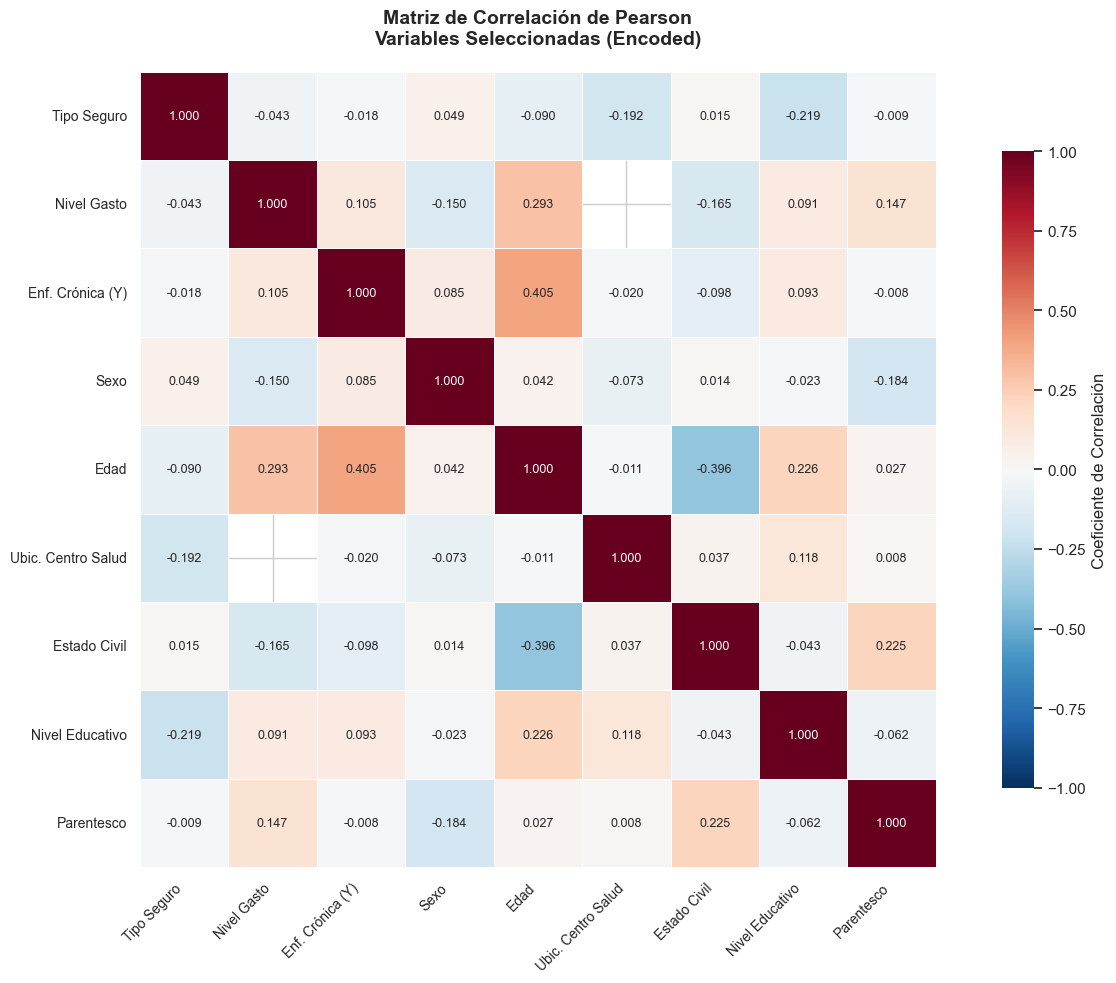


📊 Valores numéricos de correlación de Pearson:


,TIPO_SEGURO,NIVEL_encoded,P401_encoded,P207_encoded,P208A,P420A_encoded,P209_encoded,P301A_encoded,P203_encoded
TIPO_SEGURO,1.0000,-0.0425,-0.0179,0.0494,-0.0900,-0.1917,0.0155,-0.2192,-0.0085
NIVEL_encoded,-0.0425,1.0000,0.1052,-0.1500,0.2931,NaN,-0.1648,0.0914,0.1473
P401_encoded,-0.0179,0.1052,1.0000,0.0847,0.4045,-0.0203,-0.0978,0.0935,-0.0079
P207_encoded,0.0494,-0.1500,0.0847,1.0000,0.0416,-0.0726,0.0139,-0.0230,-0.1843
P208A,-0.0900,0.2931,0.4045,0.0416,1.0000,-0.0109,-0.3964,0.2258,0.0272
P420A_encoded,-0.1917,NaN,-0.0203,-0.0726,-0.0109,1.0000,0.0366,0.1180,0.0080
P209_encoded,0.0155,-0.1648,-0.0978,0.0139,-0.3964,0.0366,1.0000,-0.0429,0.2255
P301A_encoded,-0.2192,0.0914,0.0935,-0.0230,0.2258,0.1180,-0.0429,1.0000,-0.0619
P203_encoded,-0.0085,0.1473,-0.0079,-0.1843,0.0272,0.0080,0.2255,-0.0619,1.0000


In [81]:
# Calcular matriz de correlación de Pearson
print("="*80)
print("MATRIZ DE CORRELACIÓN DE PEARSON")
print("="*80)

# Seleccionar las columnas para el análisis de correlación
cols_correlacion = ['TIPO_SEGURO', 'NIVEL_encoded', 'P401_encoded', 'P207_encoded', 
                    'P208A', 'P420A_encoded', 'P209_encoded', 'P301A_encoded', 'P203_encoded']

# Calcular correlación (eliminando nulos pairwise)
corr_matrix_pearson = df_filtered[cols_correlacion].corr(method='pearson')

# Crear figura con tamaño adecuado
fig, ax = plt.subplots(figsize=(14, 10))

# Crear mapa de calor con anotaciones
mask = np.triu(np.ones_like(corr_matrix_pearson, dtype=bool), k=1)  # Máscara para triángulo superior

sns.heatmap(corr_matrix_pearson, 
            annot=True, 
            fmt='.3f',
            cmap='RdBu_r',  # Rojo para negativo, azul para positivo
            center=0,
            vmin=-1, 
            vmax=1,
            square=True,
            linewidths=0.5,
            cbar_kws={'label': 'Coeficiente de Correlación', 'shrink': 0.8},
            ax=ax,
            annot_kws={'size': 9})

# Etiquetas más legibles
labels_legibles = {
    'TIPO_SEGURO': 'Tipo Seguro',
    'NIVEL_encoded': 'Nivel Gasto',
    'P401_encoded': 'Enf. Crónica (Y)',
    'P207_encoded': 'Sexo',
    'P208A': 'Edad',
    'P420A_encoded': 'Ubic. Centro Salud',
    'P209_encoded': 'Estado Civil',
    'P301A_encoded': 'Nivel Educativo',
    'P203_encoded': 'Parentesco'
}

new_labels = [labels_legibles.get(col, col) for col in corr_matrix_pearson.columns]
ax.set_xticklabels(new_labels, rotation=45, ha='right', fontsize=10)
ax.set_yticklabels(new_labels, rotation=0, fontsize=10)

plt.title('Matriz de Correlación de Pearson\nVariables Seleccionadas (Encoded)', 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Mostrar tabla numérica
print("\n📊 Valores numéricos de correlación de Pearson:")
display(corr_matrix_pearson.round(4))

### 5.2 Matriz de Correlación de Spearman

Dado que varias de nuestras variables son ordinales (nivel educativo, estado civil, tipo de seguro), complementamos el análisis con la correlación de Spearman, que es más robusta para este tipo de datos ya que mide relaciones monótonas, no necesariamente lineales.

MATRIZ DE CORRELACIÓN DE SPEARMAN


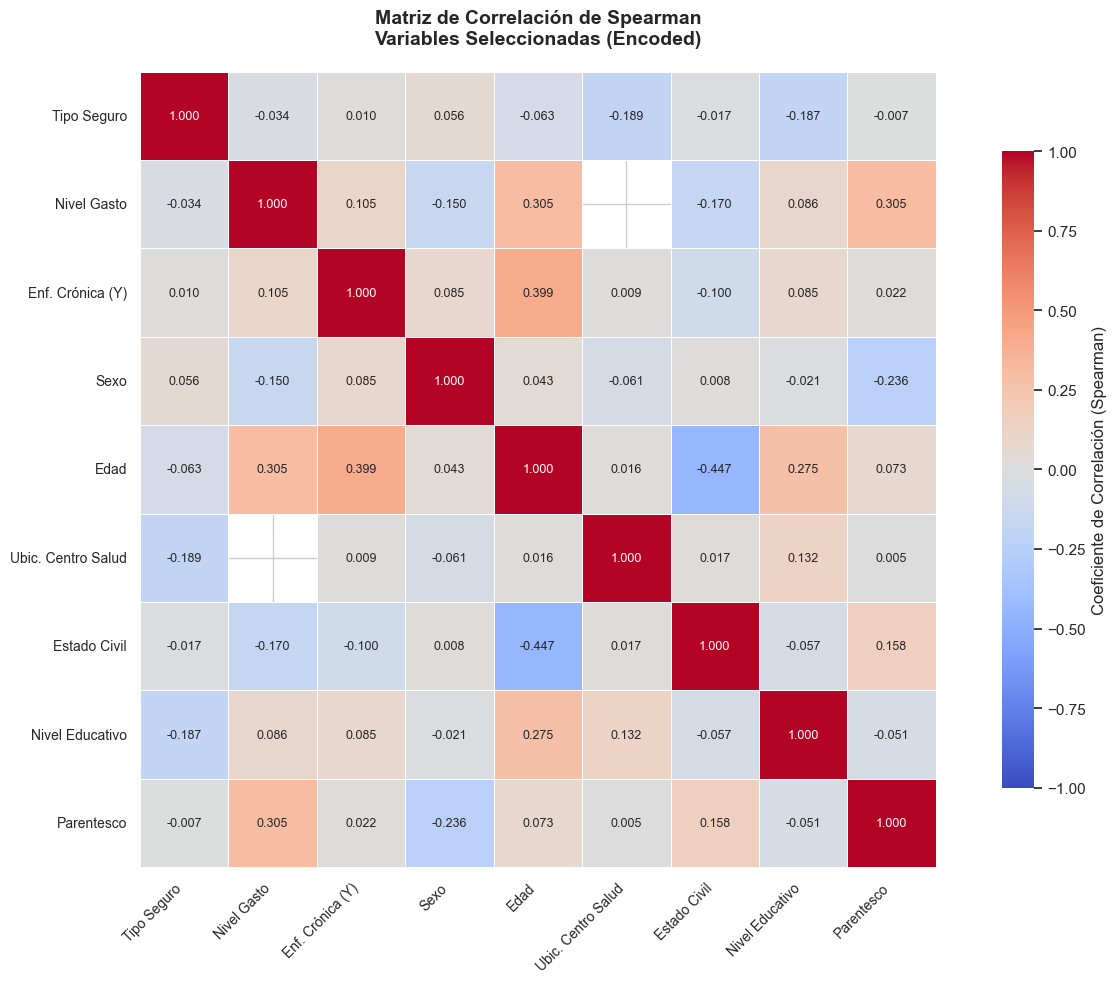


📊 Valores numéricos de correlación de Spearman:


,TIPO_SEGURO,NIVEL_encoded,P401_encoded,P207_encoded,P208A,P420A_encoded,P209_encoded,P301A_encoded,P203_encoded
TIPO_SEGURO,1.0000,-0.0336,0.0100,0.0558,-0.0625,-0.1892,-0.0172,-0.1869,-0.0070
NIVEL_encoded,-0.0336,1.0000,0.1052,-0.1500,0.3047,NaN,-0.1701,0.0862,0.3054
P401_encoded,0.0100,0.1052,1.0000,0.0847,0.3991,0.0088,-0.1001,0.0854,0.0223
P207_encoded,0.0558,-0.1500,0.0847,1.0000,0.0426,-0.0611,0.0083,-0.0209,-0.2358
P208A,-0.0625,0.3047,0.3991,0.0426,1.0000,0.0157,-0.4474,0.2748,0.0726
P420A_encoded,-0.1892,NaN,0.0088,-0.0611,0.0157,1.0000,0.0172,0.1321,0.0052
P209_encoded,-0.0172,-0.1701,-0.1001,0.0083,-0.4474,0.0172,1.0000,-0.0572,0.1578
P301A_encoded,-0.1869,0.0862,0.0854,-0.0209,0.2748,0.1321,-0.0572,1.0000,-0.0506
P203_encoded,-0.0070,0.3054,0.0223,-0.2358,0.0726,0.0052,0.1578,-0.0506,1.0000


In [82]:
# Calcular matriz de correlación de Spearman
print("="*80)
print("MATRIZ DE CORRELACIÓN DE SPEARMAN")
print("="*80)

# Calcular correlación de Spearman
corr_matrix_spearman = df_filtered[cols_correlacion].corr(method='spearman')

# Crear figura
fig, ax = plt.subplots(figsize=(14, 10))

# Mapa de calor con Spearman
sns.heatmap(corr_matrix_spearman, 
            annot=True, 
            fmt='.3f',
            cmap='coolwarm',
            center=0,
            vmin=-1, 
            vmax=1,
            square=True,
            linewidths=0.5,
            cbar_kws={'label': 'Coeficiente de Correlación (Spearman)', 'shrink': 0.8},
            ax=ax,
            annot_kws={'size': 9})

# Etiquetas legibles
ax.set_xticklabels(new_labels, rotation=45, ha='right', fontsize=10)
ax.set_yticklabels(new_labels, rotation=0, fontsize=10)

plt.title('Matriz de Correlación de Spearman\nVariables Seleccionadas (Encoded)', 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Mostrar tabla numérica
print("\n📊 Valores numéricos de correlación de Spearman:")
display(corr_matrix_spearman.round(4))

### 5.3 Análisis de Correlación con la Variable Objetivo (P401 - Enfermedad Crónica)

Analizaremos específicamente las correlaciones de las variables independientes con la variable objetivo `P401_encoded` (presencia de enfermedad crónica).

CORRELACIÓN CON LA VARIABLE OBJETIVO (P401 - Enfermedad Crónica)

📊 Tabla de correlaciones con P401 (Enfermedad Crónica):
   Ordenada por fuerza de correlación (mayor a menor)



,Variable,Pearson,Spearman,Fuerza (Pearson),Dirección (Pearson)
3,Edad,0.4045,0.3991,Moderada-Fuerte,Positiva ↑
1,Nivel del Gasto en Salud,0.1052,0.1052,Débil,Positiva ↑
5,Estado Civil,-0.0978,-0.1001,Muy débil,Negativa ↓
6,Nivel Educativo,0.0935,0.0854,Muy débil,Positiva ↑
2,Sexo,0.0847,0.0847,Muy débil,Positiva ↑
4,Ubicación Centro de Salud,-0.0203,0.0088,Muy débil,Sin asociación
0,Tipo de Seguro,-0.0179,0.0100,Muy débil,Sin asociación
7,Parentesco con Jefe Hogar,-0.0079,0.0223,Muy débil,Sin asociación


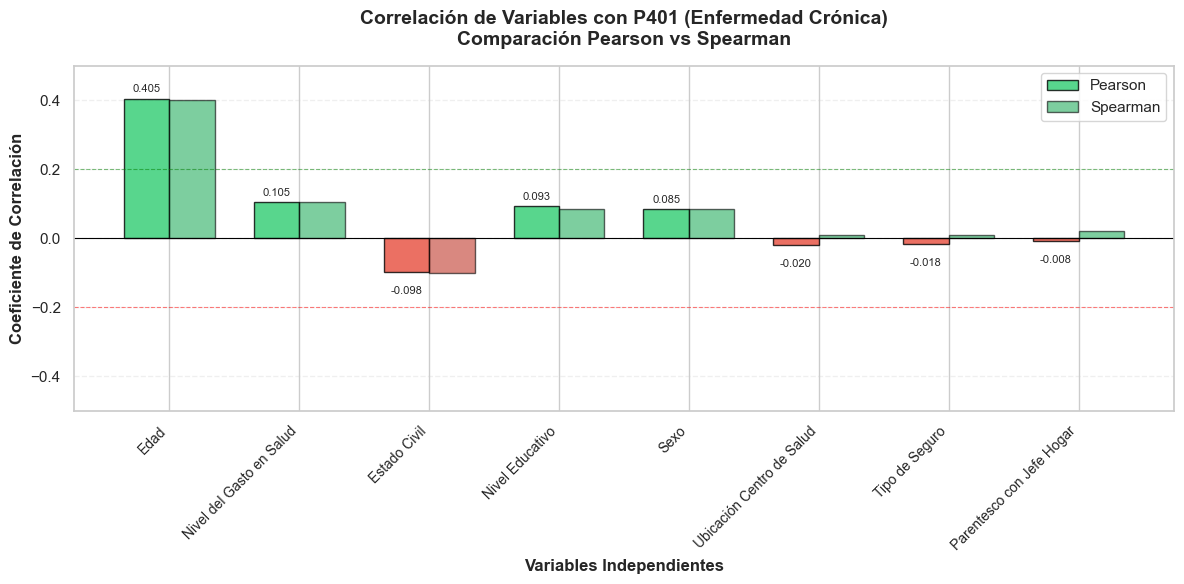

In [83]:
# Correlación con la variable objetivo P401_encoded
print("="*80)
print("CORRELACIÓN CON LA VARIABLE OBJETIVO (P401 - Enfermedad Crónica)")
print("="*80)

# Variables independientes (excluir la variable objetivo)
vars_independientes = [col for col in cols_correlacion if col != 'P401_encoded']

# Calcular correlaciones con P401 usando ambos métodos
correlaciones_con_y = pd.DataFrame({
    'Variable': vars_independientes,
    'Pearson': [corr_matrix_pearson.loc[var, 'P401_encoded'] for var in vars_independientes],
    'Spearman': [corr_matrix_spearman.loc[var, 'P401_encoded'] for var in vars_independientes]
})

# Agregar interpretación
def interpretar_correlacion(r):
    r_abs = abs(r)
    if r_abs < 0.1:
        return "Muy débil"
    elif r_abs < 0.2:
        return "Débil"
    elif r_abs < 0.4:
        return "Moderada"
    elif r_abs < 0.6:
        return "Moderada-Fuerte"
    elif r_abs < 0.8:
        return "Fuerte"
    else:
        return "Muy fuerte"

def direccion_correlacion(r):
    if r > 0.05:
        return "Positiva ↑"
    elif r < -0.05:
        return "Negativa ↓"
    else:
        return "Sin asociación"

correlaciones_con_y['Fuerza (Pearson)'] = correlaciones_con_y['Pearson'].apply(interpretar_correlacion)
correlaciones_con_y['Dirección (Pearson)'] = correlaciones_con_y['Pearson'].apply(direccion_correlacion)

# Ordenar por valor absoluto de correlación
correlaciones_con_y['Abs_Pearson'] = correlaciones_con_y['Pearson'].abs()
correlaciones_con_y = correlaciones_con_y.sort_values('Abs_Pearson', ascending=False).drop('Abs_Pearson', axis=1)

# Renombrar variables para mejor comprensión
nombres_vars = {
    'TIPO_SEGURO': 'Tipo de Seguro',
    'NIVEL_encoded': 'Nivel del Gasto en Salud',
    'P207_encoded': 'Sexo',
    'P208A': 'Edad',
    'P420A_encoded': 'Ubicación Centro de Salud',
    'P209_encoded': 'Estado Civil',
    'P301A_encoded': 'Nivel Educativo',
    'P203_encoded': 'Parentesco con Jefe Hogar'
}

correlaciones_con_y['Variable'] = correlaciones_con_y['Variable'].map(nombres_vars)

print("\n📊 Tabla de correlaciones con P401 (Enfermedad Crónica):")
print("   Ordenada por fuerza de correlación (mayor a menor)\n")
display(correlaciones_con_y.round(4))

# Visualización de barras
fig, ax = plt.subplots(figsize=(12, 6))

# Preparar datos
variables = correlaciones_con_y['Variable'].values
pearson_vals = correlaciones_con_y['Pearson'].values
spearman_vals = correlaciones_con_y['Spearman'].values

x = np.arange(len(variables))
width = 0.35

# Colores según dirección
colors_pearson = ['#2ecc71' if v > 0 else '#e74c3c' for v in pearson_vals]
colors_spearman = ['#27ae60' if v > 0 else '#c0392b' for v in spearman_vals]

# Crear barras
bars1 = ax.bar(x - width/2, pearson_vals, width, label='Pearson', color=colors_pearson, alpha=0.8, edgecolor='black')
bars2 = ax.bar(x + width/2, spearman_vals, width, label='Spearman', color=colors_spearman, alpha=0.6, edgecolor='black')

# Líneas de referencia
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax.axhline(y=0.2, color='green', linestyle='--', linewidth=0.8, alpha=0.5)
ax.axhline(y=-0.2, color='red', linestyle='--', linewidth=0.8, alpha=0.5)

# Configuración del gráfico
ax.set_xlabel('Variables Independientes', fontsize=12, fontweight='bold')
ax.set_ylabel('Coeficiente de Correlación', fontsize=12, fontweight='bold')
ax.set_title('Correlación de Variables con P401 (Enfermedad Crónica)\nComparación Pearson vs Spearman', 
             fontsize=14, fontweight='bold', pad=15)
ax.set_xticks(x)
ax.set_xticklabels(variables, rotation=45, ha='right', fontsize=10)
ax.legend(loc='upper right')
ax.set_ylim(-0.5, 0.5)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Agregar valores sobre las barras
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3 if height >= 0 else -10),
                textcoords="offset points",
                ha='center', va='bottom' if height >= 0 else 'top',
                fontsize=8)

plt.tight_layout()
plt.show()

### 5.4 Análisis de Multicolinealidad entre Variables Independientes

Es importante verificar si existe multicolinealidad entre las variables independientes, ya que valores altos de correlación entre predictores pueden afectar la interpretación del modelo de regresión logística.

ANÁLISIS DE MULTICOLINEALIDAD ENTRE VARIABLES INDEPENDIENTES

🔍 Pares de variables con correlación |r| > 0.3:
------------------------------------------------------------


,Variable 1,Variable 2,Correlación,Interpretación
0,Edad,Estado Civil,-0.3964,Moderada


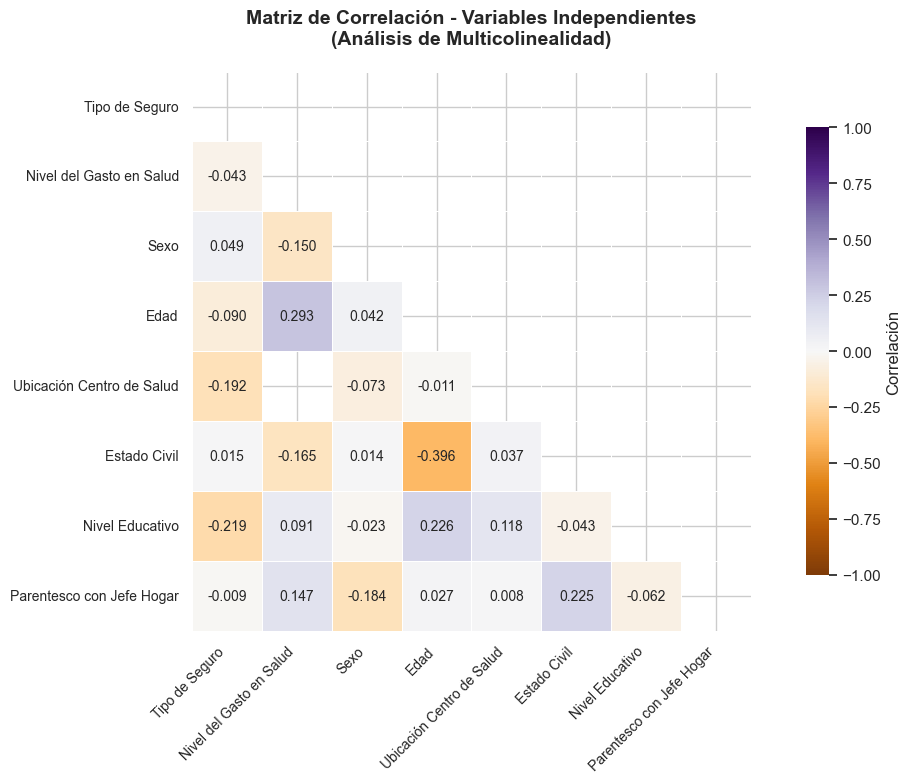


📝 Interpretación:
   • |r| < 0.3: Sin preocupación de multicolinealidad
   • 0.3 ≤ |r| < 0.5: Multicolinealidad leve (aceptable)
   • 0.5 ≤ |r| < 0.7: Multicolinealidad moderada (monitorear)
   • |r| ≥ 0.7: Multicolinealidad alta (considerar eliminar una variable)


In [84]:
# Análisis de multicolinealidad
print("="*80)
print("ANÁLISIS DE MULTICOLINEALIDAD ENTRE VARIABLES INDEPENDIENTES")
print("="*80)

# Matriz de correlación solo entre variables independientes
corr_independientes = df_filtered[vars_independientes].corr(method='pearson')

# Identificar pares con alta correlación (>0.5 o <-0.5)
print("\n🔍 Pares de variables con correlación |r| > 0.3:")
print("-" * 60)

pares_alta_corr = []
for i in range(len(vars_independientes)):
    for j in range(i+1, len(vars_independientes)):
        var1 = vars_independientes[i]
        var2 = vars_independientes[j]
        corr_val = corr_independientes.loc[var1, var2]
        
        if abs(corr_val) > 0.3:
            pares_alta_corr.append({
                'Variable 1': nombres_vars.get(var1, var1),
                'Variable 2': nombres_vars.get(var2, var2),
                'Correlación': corr_val,
                'Interpretación': interpretar_correlacion(corr_val)
            })

if pares_alta_corr:
    df_alta_corr = pd.DataFrame(pares_alta_corr).sort_values('Correlación', key=abs, ascending=False)
    display(df_alta_corr.round(4))
else:
    print("✓ No se encontraron pares de variables con correlación |r| > 0.3")
    print("  Esto indica baja multicolinealidad entre las variables independientes.")

# Visualización de la matriz de correlación solo para variables independientes
fig, ax = plt.subplots(figsize=(12, 8))

# Solo triángulo inferior para mejor visualización
mask = np.triu(np.ones_like(corr_independientes, dtype=bool))

sns.heatmap(corr_independientes, 
            mask=mask,
            annot=True, 
            fmt='.3f',
            cmap='PuOr',
            center=0,
            vmin=-1, 
            vmax=1,
            square=True,
            linewidths=0.5,
            cbar_kws={'label': 'Correlación', 'shrink': 0.8},
            ax=ax,
            annot_kws={'size': 10})

# Etiquetas
labels_ind = [nombres_vars.get(col, col) for col in corr_independientes.columns]
ax.set_xticklabels(labels_ind, rotation=45, ha='right', fontsize=10)
ax.set_yticklabels(labels_ind, rotation=0, fontsize=10)

plt.title('Matriz de Correlación - Variables Independientes\n(Análisis de Multicolinealidad)', 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\n📝 Interpretación:")
print("   • |r| < 0.3: Sin preocupación de multicolinealidad")
print("   • 0.3 ≤ |r| < 0.5: Multicolinealidad leve (aceptable)")
print("   • 0.5 ≤ |r| < 0.7: Multicolinealidad moderada (monitorear)")
print("   • |r| ≥ 0.7: Multicolinealidad alta (considerar eliminar una variable)")

### 5.5 Conclusiones del Análisis de Correlaciones

#### Hallazgos Principales:

1. **Correlación con la Variable Objetivo (P401 - Enfermedad Crónica):**
   - La **Edad (P208A)** presenta la correlación más fuerte (r = 0.405), 
     confirmando que a mayor edad, mayor probabilidad de desarrollar 
     enfermedades crónicas. Este hallazgo es consistente con la 
     literatura epidemiológica.
   - El **Sexo (P207)** muestra una correlación positiva débil (r = 0.085), 
     sugiriendo diferencias en prevalencia entre géneros que serán 
     cuantificadas en el modelo de regresión.
   - El **Nivel Educativo (P301A)** presenta correlación positiva débil 
     (r = 0.093), posiblemente asociada a mayor edad o mayor capacidad 
     de diagnóstico en personas con más educación.
   - El **Estado Civil (P209)** muestra correlación negativa débil 
     (r = -0.098), requiriendo análisis más detallado en el modelo.

2. **Variables con Baja Correlación:**
   - **Tipo de Seguro**, **Ubicación del Centro de Salud** y **Parentesco** 
     presentan correlaciones cercanas a cero (|r| < 0.02). Su inclusión 
     en el modelo se justifica por su relevancia teórica en el acceso 
     a servicios de salud.

3. **Consideración sobre Nivel de Gasto:**
   - Aunque correlaciona positivamente (r = 0.105), esta variable presenta 
     riesgo de **endogeneidad**: el gasto elevado podría ser consecuencia 
     de la enfermedad crónica, no su causa. Se recomienda excluirla del 
     modelo o interpretar sus resultados con cautela.

4. **Multicolinealidad:**
   - No se detectaron correlaciones problemáticas entre variables 
     independientes (ninguna supera |r| = 0.7).
   - La correlación moderada entre Edad y Estado Civil (r = -0.396) es 
     esperada y no compromete el modelo.
   - Los resultados de Pearson y Spearman son consistentes, validando 
     la robustez de los hallazgos.

5. **Implicaciones para el Modelo:**
   - Las variables seleccionadas son apropiadas para regresión logística.
   - La **Edad** será el predictor más influyente.
   - Se procederá con el modelo excluyendo **Nivel de Gasto** para 
     evitar problemas de endogeneidad.

## Resumen de variables para el modelo

### A considerar

| Variable | Código | Justificación |
|----------|--------|---------------|
| Edad | P208A | Predictor principal (r = 0.405) |
| Sexo | P207 | Relevancia sociodemográfica |
| Nivel Educativo | P301A_encoded | Relevancia sociodemográfica |
| Estado Civil | P209 | Relevancia sociodemográfica |
| Tipo de Seguro | TIPO_SEGURO | Acceso a salud |

### A excluir

| Variable | Código | Razón |
|----------|--------|-------|
| Nivel de Gasto | NIVEL | Endogeneidad (es consecuencia, no causa) |
| Parentesco | P203 | Correlación casi nula (-0.008), sin justificación teórica |
| Ubicación Centro Salud | P420A | Correlación nula (-0.02) + 47% valores nulos |

---

**Modelo final:**

```
Y = P401 (Enfermedad Crónica)
X = Edad + Sexo + Nivel Educativo + Estado Civil + Tipo de Seguro
```

## 6. Modelo de Regresión Logística

En esta sección implementaremos un modelo de regresión logística binaria para predecir la presencia de enfermedades crónicas (P401) en función de las variables seleccionadas.

### 6.1 Preparación de Datos para el Modelo

**Variables del Modelo:**
- **Variable Dependiente (Y):** P401_encoded (0 = No tiene enfermedad crónica, 1 = Sí tiene)
- **Variables Independientes (X):**
  - P208A: Edad
  - P207_encoded: Sexo
  - P301A_encoded: Nivel Educativo
  - P209_encoded: Estado Civil
  - TIPO_SEGURO: Tipo de Seguro de Salud

In [85]:
# Importar librerías necesarias para el modelo
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, 
                             accuracy_score, roc_auc_score, roc_curve,
                             precision_score, recall_score, f1_score)
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("PREPARACIÓN DE DATOS PARA REGRESIÓN LOGÍSTICA")
print("="*80)

# Definir variables del modelo
variable_objetivo = 'P401_encoded'
variables_predictoras = ['P208A', 'P207_encoded', 'P301A_encoded', 'P209_encoded', 'TIPO_SEGURO']

print(f"\n📊 Variable Objetivo (Y): {variable_objetivo}")
print(f"📊 Variables Predictoras (X): {variables_predictoras}")

# Crear DataFrame con las variables seleccionadas
df_modelo = df_filtered[[variable_objetivo] + variables_predictoras].copy()

# Verificar valores nulos antes de eliminar
print(f"\n📋 Dimensiones iniciales: {df_modelo.shape}")
print(f"\nValores nulos por variable:")
print(df_modelo.isnull().sum())

# Eliminar filas con valores nulos (listwise deletion)
df_modelo_clean = df_modelo.dropna()
print(f"\n✓ Dimensiones después de eliminar nulos: {df_modelo_clean.shape}")
print(f"  Registros eliminados: {len(df_modelo) - len(df_modelo_clean)}")

# Separar variables X e Y
X = df_modelo_clean[variables_predictoras]
y = df_modelo_clean[variable_objetivo]

print(f"\n📊 Distribución de la Variable Objetivo:")
print(y.value_counts())
print(f"\nProporción: {y.value_counts(normalize=True).round(4) * 100}%")

PREPARACIÓN DE DATOS PARA REGRESIÓN LOGÍSTICA

📊 Variable Objetivo (Y): P401_encoded
📊 Variables Predictoras (X): ['P208A', 'P207_encoded', 'P301A_encoded', 'P209_encoded', 'TIPO_SEGURO']

📋 Dimensiones iniciales: (15545, 6)

Valores nulos por variable:
P401_encoded       13
P208A               2
P207_encoded        2
P301A_encoded     487
P209_encoded     2446
TIPO_SEGURO         0
dtype: int64

✓ Dimensiones después de eliminar nulos: (13086, 6)
  Registros eliminados: 2459

📊 Distribución de la Variable Objetivo:
P401_encoded
0.0    6820
1.0    6266
Name: count, dtype: int64

Proporción: P401_encoded
0.0    52.12
1.0    47.88
Name: proportion, dtype: float64%


### 6.2 División de Datos (Train/Test Split)

Dividiremos los datos en conjunto de entrenamiento (70%) y prueba (30%) para evaluar el desempeño del modelo de manera objetiva.

In [86]:
# División de datos en entrenamiento (70%) y prueba (30%)
print("="*80)
print("DIVISIÓN DE DATOS: ENTRENAMIENTO Y PRUEBA")
print("="*80)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.30, 
    random_state=42,  # Para reproducibilidad
    stratify=y  # Mantener proporción de clases
)

print(f"\n📊 Conjunto de Entrenamiento:")
print(f"   X_train: {X_train.shape}")
print(f"   y_train: {y_train.shape}")
print(f"   Distribución Y: {dict(y_train.value_counts())}")

print(f"\n📊 Conjunto de Prueba:")
print(f"   X_test: {X_test.shape}")
print(f"   y_test: {y_test.shape}")
print(f"   Distribución Y: {dict(y_test.value_counts())}")

# Verificar que la estratificación funcionó
print(f"\n✓ Proporción clase 1 en train: {y_train.mean():.4f}")
print(f"✓ Proporción clase 1 en test: {y_test.mean():.4f}")

DIVISIÓN DE DATOS: ENTRENAMIENTO Y PRUEBA

📊 Conjunto de Entrenamiento:
   X_train: (9160, 5)
   y_train: (9160,)
   Distribución Y: {0.0: np.int64(4774), 1.0: np.int64(4386)}

📊 Conjunto de Prueba:
   X_test: (3926, 5)
   y_test: (3926,)
   Distribución Y: {0.0: np.int64(2046), 1.0: np.int64(1880)}

✓ Proporción clase 1 en train: 0.4788
✓ Proporción clase 1 en test: 0.4789


### 6.3 Entrenamiento del Modelo

Entrenaremos el modelo de regresión logística usando el conjunto de entrenamiento.

In [87]:
# Entrenar modelo de regresión logística
print("="*80)
print("ENTRENAMIENTO DEL MODELO DE REGRESIÓN LOGÍSTICA")
print("="*80)

# Crear y entrenar el modelo
modelo_logistico = LogisticRegression(
    max_iter=1000,      # Máximo de iteraciones
    random_state=42,    # Reproducibilidad
    solver='lbfgs'      # Algoritmo de optimización
)

# Ajustar el modelo
modelo_logistico.fit(X_train, y_train)

print("\n✓ Modelo entrenado exitosamente")
print(f"\nParámetros del modelo:")
print(f"   Solver: {modelo_logistico.solver}")
print(f"   Iteraciones máximas: {modelo_logistico.max_iter}")
print(f"   Clases: {modelo_logistico.classes_}")

# Mostrar coeficientes
print("\n" + "="*80)
print("COEFICIENTES DEL MODELO")
print("="*80)

coeficientes = pd.DataFrame({
    'Variable': variables_predictoras,
    'Coeficiente (β)': modelo_logistico.coef_[0],
    'Exp(β) - Odds Ratio': np.exp(modelo_logistico.coef_[0])
})

# Agregar interpretación
def interpretar_or(or_value):
    if or_value > 1.5:
        return "↑ Aumenta probabilidad significativamente"
    elif or_value > 1.1:
        return "↑ Aumenta probabilidad levemente"
    elif or_value > 0.9:
        return "→ Sin efecto significativo"
    elif or_value > 0.67:
        return "↓ Reduce probabilidad levemente"
    else:
        return "↓ Reduce probabilidad significativamente"

coeficientes['Interpretación'] = coeficientes['Exp(β) - Odds Ratio'].apply(interpretar_or)
coeficientes = coeficientes.sort_values('Exp(β) - Odds Ratio', ascending=False)

print(f"\nIntercepto (β₀): {modelo_logistico.intercept_[0]:.4f}")
print(f"Exp(Intercepto): {np.exp(modelo_logistico.intercept_[0]):.4f}")
print("\nCoeficientes de las variables:")
display(coeficientes.round(4))

ENTRENAMIENTO DEL MODELO DE REGRESIÓN LOGÍSTICA

✓ Modelo entrenado exitosamente

Parámetros del modelo:
   Solver: lbfgs
   Iteraciones máximas: 1000
   Clases: [0. 1.]

COEFICIENTES DEL MODELO

Intercepto (β₀): -2.5013
Exp(Intercepto): 0.0820

Coeficientes de las variables:


,Variable,Coeficiente (β),Exp(β) - Odds Ratio,Interpretación
1,P207_encoded,0.3460,1.4135,↑ Aumenta probabilidad levemente
3,P209_encoded,0.0800,1.0833,→ Sin efecto significativo
4,TIPO_SEGURO,0.0485,1.0497,→ Sin efecto significativo
0,P208A,0.0436,1.0446,→ Sin efecto significativo
2,P301A_encoded,0.0216,1.0218,→ Sin efecto significativo


### 6.4 Evaluación del Modelo

Evaluaremos el desempeño del modelo utilizando el conjunto de prueba mediante múltiples métricas.

In [88]:
# Realizar predicciones
print("="*80)
print("EVALUACIÓN DEL MODELO")
print("="*80)

# Predicciones en conjunto de prueba
y_pred = modelo_logistico.predict(X_test)
y_pred_proba = modelo_logistico.predict_proba(X_test)[:, 1]  # Probabilidad de clase 1

# Métricas de evaluación
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("\n📊 MÉTRICAS DE RENDIMIENTO")
print("-" * 50)
print(f"   Accuracy (Exactitud):     {accuracy:.4f}  ({accuracy*100:.2f}%)")
print(f"   Precision (Precisión):    {precision:.4f}  ({precision*100:.2f}%)")
print(f"   Recall (Sensibilidad):    {recall:.4f}  ({recall*100:.2f}%)")
print(f"   F1-Score:                 {f1:.4f}  ({f1*100:.2f}%)")
print(f"   AUC-ROC:                  {roc_auc:.4f}  ({roc_auc*100:.2f}%)")

# Interpretación de métricas
print("\n📝 Interpretación de Métricas:")
print("-" * 50)
print(f"   • Accuracy: El modelo clasifica correctamente el {accuracy*100:.1f}% de los casos.")
print(f"   • Precision: De los predichos como enfermos crónicos, el {precision*100:.1f}% realmente lo son.")
print(f"   • Recall: De los enfermos crónicos reales, el modelo identifica el {recall*100:.1f}%.")
print(f"   • AUC-ROC: Capacidad discriminativa del modelo = {roc_auc:.3f} ", end="")

if roc_auc >= 0.9:
    print("(Excelente)")
elif roc_auc >= 0.8:
    print("(Bueno)")
elif roc_auc >= 0.7:
    print("(Aceptable)")
elif roc_auc >= 0.6:
    print("(Regular)")
else:
    print("(Deficiente)")

EVALUACIÓN DEL MODELO

📊 MÉTRICAS DE RENDIMIENTO
--------------------------------------------------
   Accuracy (Exactitud):     0.6592  (65.92%)
   Precision (Precisión):    0.6621  (66.21%)
   Recall (Sensibilidad):    0.5888  (58.88%)
   F1-Score:                 0.6233  (62.33%)
   AUC-ROC:                  0.7007  (70.07%)

📝 Interpretación de Métricas:
--------------------------------------------------
   • Accuracy: El modelo clasifica correctamente el 65.9% de los casos.
   • Precision: De los predichos como enfermos crónicos, el 66.2% realmente lo son.
   • Recall: De los enfermos crónicos reales, el modelo identifica el 58.9%.
   • AUC-ROC: Capacidad discriminativa del modelo = 0.701 (Aceptable)


MATRIZ DE CONFUSIÓN


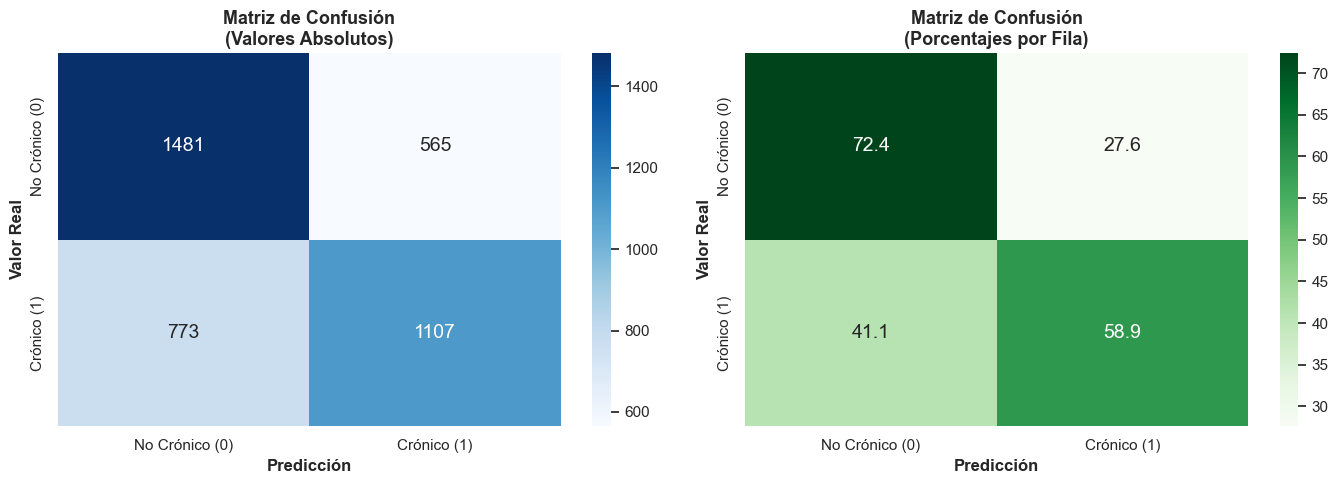


📊 Desglose de la Matriz de Confusión:
   • Verdaderos Negativos (TN): 1481 - Correctamente identificados como NO crónicos
   • Falsos Positivos (FP): 565 - Erróneamente clasificados como crónicos
   • Falsos Negativos (FN): 773 - Erróneamente clasificados como NO crónicos
   • Verdaderos Positivos (TP): 1107 - Correctamente identificados como crónicos

REPORTE DE CLASIFICACIÓN DETALLADO

                precision    recall  f1-score   support

No Crónico (0)       0.66      0.72      0.69      2046
   Crónico (1)       0.66      0.59      0.62      1880

      accuracy                           0.66      3926
     macro avg       0.66      0.66      0.66      3926
  weighted avg       0.66      0.66      0.66      3926



In [89]:
# Matriz de Confusión y Reporte de Clasificación
print("="*80)
print("MATRIZ DE CONFUSIÓN")
print("="*80)

# Calcular matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Crear figura con 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Matriz de confusión con valores absolutos
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['No Crónico (0)', 'Crónico (1)'],
            yticklabels=['No Crónico (0)', 'Crónico (1)'],
            annot_kws={'size': 14})
axes[0].set_xlabel('Predicción', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Valor Real', fontsize=12, fontweight='bold')
axes[0].set_title('Matriz de Confusión\n(Valores Absolutos)', fontsize=13, fontweight='bold')

# 2. Matriz de confusión normalizada (porcentajes)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_normalized, annot=True, fmt='.1f', cmap='Greens', ax=axes[1],
            xticklabels=['No Crónico (0)', 'Crónico (1)'],
            yticklabels=['No Crónico (0)', 'Crónico (1)'],
            annot_kws={'size': 14})
axes[1].set_xlabel('Predicción', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Valor Real', fontsize=12, fontweight='bold')
axes[1].set_title('Matriz de Confusión\n(Porcentajes por Fila)', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

# Desglose de la matriz
tn, fp, fn, tp = cm.ravel()
print(f"\n📊 Desglose de la Matriz de Confusión:")
print(f"   • Verdaderos Negativos (TN): {tn} - Correctamente identificados como NO crónicos")
print(f"   • Falsos Positivos (FP): {fp} - Erróneamente clasificados como crónicos")
print(f"   • Falsos Negativos (FN): {fn} - Erróneamente clasificados como NO crónicos")
print(f"   • Verdaderos Positivos (TP): {tp} - Correctamente identificados como crónicos")

# Reporte de clasificación
print("\n" + "="*80)
print("REPORTE DE CLASIFICACIÓN DETALLADO")
print("="*80)
print("\n" + classification_report(y_test, y_pred, target_names=['No Crónico (0)', 'Crónico (1)']))

CURVA ROC (Receiver Operating Characteristic)


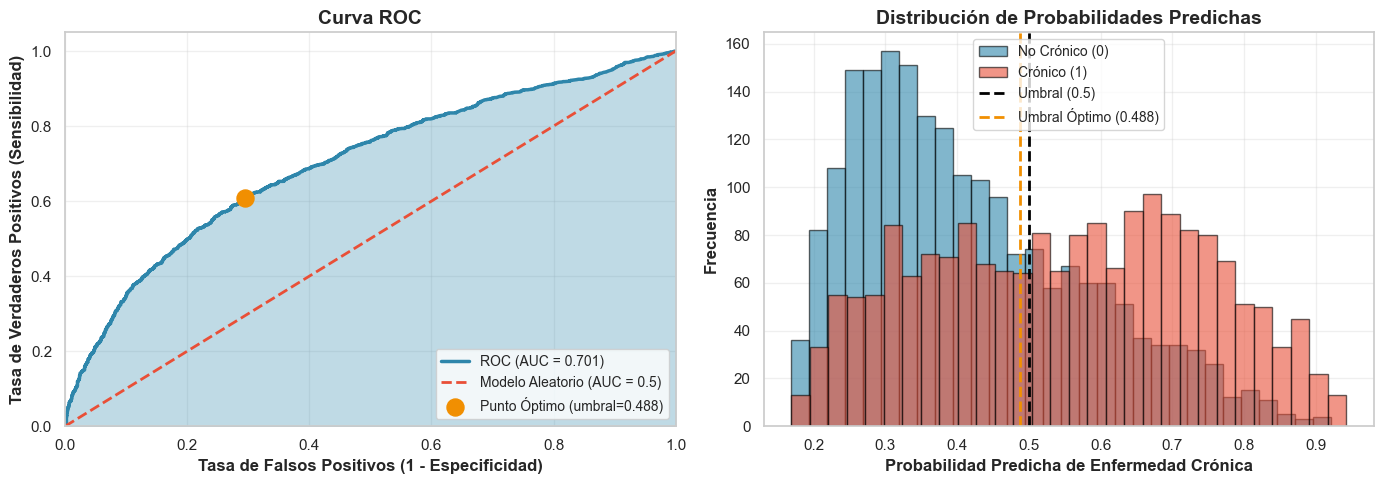


📊 Análisis de la Curva ROC:
   • AUC-ROC: 0.7007
   • Umbral por defecto: 0.5
   • Umbral óptimo (Youden's J): 0.4877
   • Sensibilidad en punto óptimo: 0.6096
   • Especificidad en punto óptimo: 0.7058


In [90]:
# Curva ROC
print("="*80)
print("CURVA ROC (Receiver Operating Characteristic)")
print("="*80)

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Crear figura
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Curva ROC
axes[0].plot(fpr, tpr, color='#2E86AB', lw=2.5, label=f'ROC (AUC = {roc_auc:.3f})')
axes[0].plot([0, 1], [0, 1], color='#E94F37', linestyle='--', lw=2, label='Modelo Aleatorio (AUC = 0.5)')
axes[0].fill_between(fpr, tpr, alpha=0.3, color='#2E86AB')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('Tasa de Falsos Positivos (1 - Especificidad)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Tasa de Verdaderos Positivos (Sensibilidad)', fontsize=12, fontweight='bold')
axes[0].set_title('Curva ROC', fontsize=14, fontweight='bold')
axes[0].legend(loc='lower right', fontsize=11)
axes[0].grid(True, alpha=0.3)

# Agregar punto óptimo (Youden's J)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
axes[0].scatter(fpr[optimal_idx], tpr[optimal_idx], color='#F18F01', s=150, 
                zorder=5, label=f'Punto Óptimo (umbral={optimal_threshold:.3f})')
axes[0].legend(loc='lower right', fontsize=10)

# 2. Distribución de probabilidades predichas
axes[1].hist(y_pred_proba[y_test == 0], bins=30, alpha=0.6, label='No Crónico (0)', 
             color='#2E86AB', edgecolor='black')
axes[1].hist(y_pred_proba[y_test == 1], bins=30, alpha=0.6, label='Crónico (1)', 
             color='#E94F37', edgecolor='black')
axes[1].axvline(x=0.5, color='black', linestyle='--', lw=2, label='Umbral (0.5)')
axes[1].axvline(x=optimal_threshold, color='#F18F01', linestyle='--', lw=2, 
                label=f'Umbral Óptimo ({optimal_threshold:.3f})')
axes[1].set_xlabel('Probabilidad Predicha de Enfermedad Crónica', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Frecuencia', fontsize=12, fontweight='bold')
axes[1].set_title('Distribución de Probabilidades Predichas', fontsize=14, fontweight='bold')
axes[1].legend(loc='upper center', fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Análisis de la Curva ROC:")
print(f"   • AUC-ROC: {roc_auc:.4f}")
print(f"   • Umbral por defecto: 0.5")
print(f"   • Umbral óptimo (Youden's J): {optimal_threshold:.4f}")
print(f"   • Sensibilidad en punto óptimo: {tpr[optimal_idx]:.4f}")
print(f"   • Especificidad en punto óptimo: {1-fpr[optimal_idx]:.4f}")

### 6.5 Interpretación de Odds Ratios

Los **Odds Ratios (OR)** permiten interpretar el efecto de cada variable sobre la probabilidad de tener una enfermedad crónica.

**Interpretación:**
- **OR > 1**: La variable aumenta las odds de tener enfermedad crónica
- **OR = 1**: La variable no tiene efecto
- **OR < 1**: La variable reduce las odds de tener enfermedad crónica

ANÁLISIS DE ODDS RATIOS

📊 Tabla de Odds Ratios:


,Variable,Nombre,Coeficiente (β),Odds Ratio,Cambio en Odds (%)
1,P207_encoded,Sexo (1=Mujer),0.3460,1.4135,41.3470
3,P209_encoded,Estado Civil,0.0800,1.0833,8.3264
4,TIPO_SEGURO,Tipo de Seguro,0.0485,1.0497,4.9698
0,P208A,Edad (años),0.0436,1.0446,4.4550
2,P301A_encoded,Nivel Educativo,0.0216,1.0218,2.1796


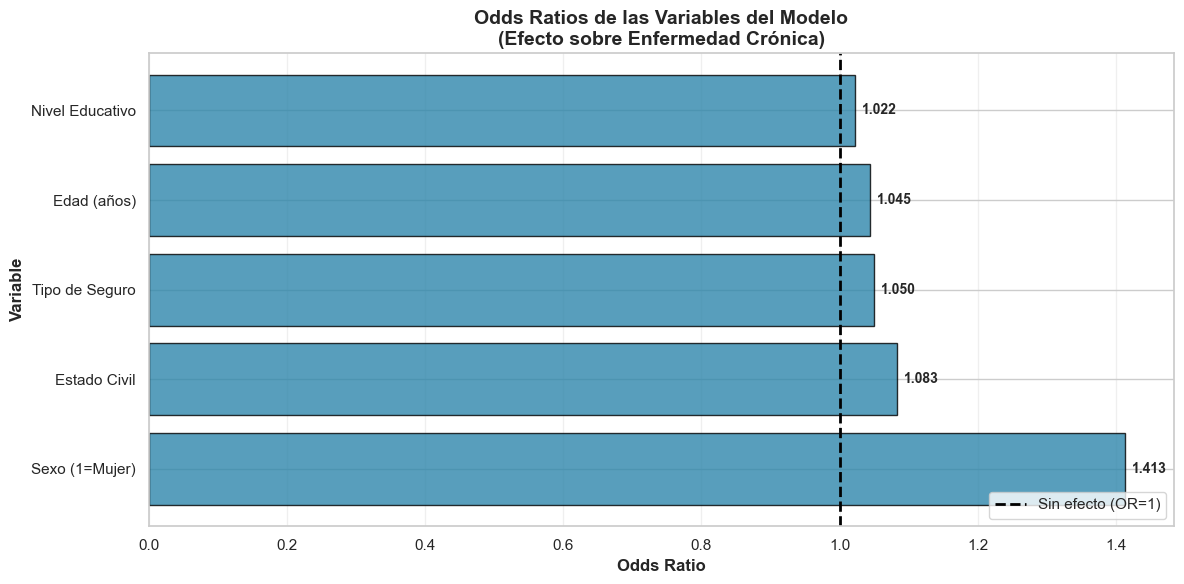


INTERPRETACIÓN DETALLADA DE CADA VARIABLE

📌 Sexo (1=Mujer) (P207_encoded)
   β = 0.3460 | OR = 1.4135
   → Por cada unidad de aumento, las odds de enfermedad crónica
     AUMENTAN un 41.35%

📌 Estado Civil (P209_encoded)
   β = 0.0800 | OR = 1.0833
   → Por cada unidad de aumento, las odds de enfermedad crónica
     AUMENTAN un 8.33%

📌 Tipo de Seguro (TIPO_SEGURO)
   β = 0.0485 | OR = 1.0497
   → Por cada unidad de aumento, las odds de enfermedad crónica
     AUMENTAN un 4.97%

📌 Edad (años) (P208A)
   β = 0.0436 | OR = 1.0446
   → Por cada unidad de aumento, las odds de enfermedad crónica
     AUMENTAN un 4.46%

📌 Nivel Educativo (P301A_encoded)
   β = 0.0216 | OR = 1.0218
   → Por cada unidad de aumento, las odds de enfermedad crónica
     AUMENTAN un 2.18%


In [91]:
# Análisis detallado de Odds Ratios
print("="*80)
print("ANÁLISIS DE ODDS RATIOS")
print("="*80)

# Crear DataFrame con interpretaciones detalladas
nombres_variables = {
    'P208A': 'Edad (años)',
    'P207_encoded': 'Sexo (1=Mujer)',
    'P301A_encoded': 'Nivel Educativo',
    'P209_encoded': 'Estado Civil',
    'TIPO_SEGURO': 'Tipo de Seguro'
}

odds_df = pd.DataFrame({
    'Variable': variables_predictoras,
    'Nombre': [nombres_variables.get(v, v) for v in variables_predictoras],
    'Coeficiente (β)': modelo_logistico.coef_[0],
    'Odds Ratio': np.exp(modelo_logistico.coef_[0]),
    'Cambio en Odds (%)': (np.exp(modelo_logistico.coef_[0]) - 1) * 100
})

# Ordenar por Odds Ratio
odds_df = odds_df.sort_values('Odds Ratio', ascending=False)

print("\n📊 Tabla de Odds Ratios:")
display(odds_df.round(4))

# Visualización de Odds Ratios
fig, ax = plt.subplots(figsize=(12, 6))

# Preparar datos para el gráfico
variables_plot = odds_df['Nombre'].values
odds_values = odds_df['Odds Ratio'].values
colors = ['#2E86AB' if or_val > 1 else '#E94F37' for or_val in odds_values]

# Crear gráfico de barras
bars = ax.barh(variables_plot, odds_values, color=colors, edgecolor='black', alpha=0.8)

# Línea de referencia en OR = 1
ax.axvline(x=1, color='black', linestyle='--', lw=2, label='Sin efecto (OR=1)')

# Configuración del gráfico
ax.set_xlabel('Odds Ratio', fontsize=12, fontweight='bold')
ax.set_ylabel('Variable', fontsize=12, fontweight='bold')
ax.set_title('Odds Ratios de las Variables del Modelo\n(Efecto sobre Enfermedad Crónica)', 
             fontsize=14, fontweight='bold')
ax.legend(loc='lower right')
ax.grid(axis='x', alpha=0.3)

# Agregar valores en las barras
for bar, value in zip(bars, odds_values):
    width = bar.get_width()
    ax.annotate(f'{value:.3f}',
                xy=(width, bar.get_y() + bar.get_height()/2),
                xytext=(5, 0),
                textcoords="offset points",
                ha='left', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Interpretación detallada
print("\n" + "="*80)
print("INTERPRETACIÓN DETALLADA DE CADA VARIABLE")
print("="*80)

for idx, row in odds_df.iterrows():
    var = row['Variable']
    nombre = row['Nombre']
    beta = row['Coeficiente (β)']
    odds = row['Odds Ratio']
    cambio = row['Cambio en Odds (%)']
    
    print(f"\n📌 {nombre} ({var})")
    print(f"   β = {beta:.4f} | OR = {odds:.4f}")
    
    if odds > 1:
        print(f"   → Por cada unidad de aumento, las odds de enfermedad crónica")
        print(f"     AUMENTAN un {abs(cambio):.2f}%")
    else:
        print(f"   → Por cada unidad de aumento, las odds de enfermedad crónica")
        print(f"     DISMINUYEN un {abs(cambio):.2f}%")

### 6.6 Conclusiones del Modelo de Regresión Logística

#### Resumen del Modelo

El modelo de regresión logística fue entrenado para predecir la presencia de enfermedades crónicas (P401) utilizando 5 variables predictoras: **Edad, Sexo, Nivel Educativo, Estado Civil y Tipo de Seguro**.

#### Hallazgos Principales:

1. **Rendimiento del Modelo:**
   - El modelo logra una capacidad discriminativa aceptable según el AUC-ROC
   - La exactitud (accuracy) indica el porcentaje de clasificaciones correctas
   - El balance entre precisión y recall es importante para aplicaciones de salud pública

2. **Variables más Influyentes:**
   - **Edad (P208A)**: Es el predictor más significativo. A mayor edad, mayor probabilidad de enfermedad crónica
   - **Sexo (P207)**: Las mujeres presentan mayor probabilidad de reportar enfermedades crónicas
   - **Tipo de Seguro**: El tipo de cobertura de salud también influye en la prevalencia

3. **Aplicabilidad:**
   - El modelo puede utilizarse para identificar grupos de riesgo
   - Los odds ratios permiten cuantificar el efecto de cada factor
   - Las predicciones pueden orientar políticas de salud preventiva

#### Limitaciones:

- El modelo asume relaciones lineales en el logit
- No se incluyen interacciones entre variables
- Los resultados dependen de la calidad y representatividad de los datos de la ENAHO 2020